# AIPI 590 - XAI | Interpretable ML
### Description: This exercise performs EDA to evaluate key assumptions of a Linear Regression, Logistic Regression and a GAM model. After evluation each model is computed and compared form an interpretability-to-performance tradeoff when predicting Customer Churn.

### Christian Moreira


[![Repo](https://img.shields.io/badge/GitHub-XAI--Interpretable--Machine--Learning-blue?logo=github)](https://github.com/U1186204/XAI-Interpretable-Machine-Learning)

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/U1186204/XAI-Interpretable-Machine-Learning/blob/main/Interpretable_ML_Chris.ipynb)

[![CI](https://github.com/U1186204/XAI-Interpretable-Machine-Learning/actions/workflows/ci.yml/badge.svg)](https://github.com/U1186204/XAI-Interpretable-Machine-Learning/actions/workflows/ci.yml)

[![CI](https://github.com/U1186204/XAI-Interpretable-Machine-Learning/actions/workflows/ci.yml/badge.svg)](https://github.com/U1186204/XAI-Interpretable-Machine-Learning/actions/workflows/ci.yml)

# Install Packages

In [7]:
!pip install kagglehub kaggle pygam

# Load Packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_ccpr
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.stats.diagnostic as diag
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import lasso_path
from statsmodels.stats import diagnostic
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, log_loss, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
from scipy.io import loadmat
from pygam import LogisticGAM, GAM, s, l
import kagglehub
from kagglehub import KaggleDatasetAdapter
import warnings
warnings.filterwarnings('ignore')

# Data Load

**The Churn dataset used in this assignment is derived from Kaggle and can be found [HERE](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data)**

**ANy references as to how I used an LLM can be found [HERE](https://github.com/U1186204/XAI-Interpretable-Machine-Learning/blob/main/LLM_Reference_Sheet.txt)**

In [9]:
# Set the path to the main CSV file (hardcoded, since listing isn't supported)
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "blastchar/telco-customer-churn",
    file_path
)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


# Task 1
Exploratory Data Analysis to check Assumptions: Perform an exploratory analysis of the dataset to understand the relationships between different features and the target variable (churn). Use appropriate visualizations and statistical methods to determine whether assumptions about linear, logistic, and GAM models are met.

### Data Dimensions, Variable Types, and Check for Missing Values

In [10]:
print("Data Structure")
print("-----------------")
print(f"Dimensions: {df.shape}")
print(f"Data Types:\n{df.dtypes}")
print(f"Missing Values:\n {df.isnull().sum()}")

Data Structure
-----------------
Dimensions: (7043, 21)
Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
Strea

### Interpretation
- Dataset has a total of 7043 observations & 21 variables
- With the exception of MonthlyCharges, tenure and senior citizen - most other variables seem categorical, including the explained variable **Churn**
- No missing fields have been reported suggesting there is not a need for imputations or deletion of observations

### Central tendencies for numerical variables, measures of dispersion for numerical variables, distributions

In [11]:
print("\n Descriptive Statistics for Numerical Variables")
print("------------------")
numeric_columns = df.select_dtypes(include=np.number).columns
print("Central Tendency Measures:")
print(df[numeric_columns].describe().loc[['mean', '50%']])
print("\n Dispersion Measures:")
print(df[numeric_columns].describe().loc[['std', 'min', 'max']])

# Distribution Normality Check
print("\n Distribution Measures:")
print(df[numeric_columns].skew())
print(df[numeric_columns].kurt())


 Descriptive Statistics for Numerical Variables
------------------
Central Tendency Measures:
      SeniorCitizen     tenure  MonthlyCharges
mean       0.162147  32.371149       64.761692
50%        0.000000  29.000000       70.350000

 Dispersion Measures:
     SeniorCitizen     tenure  MonthlyCharges
std       0.368612  24.559481       30.090047
min       0.000000   0.000000       18.250000
max       1.000000  72.000000      118.750000

 Distribution Measures:
SeniorCitizen     1.833633
tenure            0.239540
MonthlyCharges   -0.220524
dtype: float64
SeniorCitizen     1.362596
tenure           -1.387372
MonthlyCharges   -1.257260
dtype: float64


### Interpretation

**Descriptive Statistics**
- The variable SeniorCitizen appears to be a binary variable indicating whether an individual is a senior or not.
- Means and medians provide insights into the central location of the data. The mean tenure is ~32 months and the median 29 months. The mean monthly charges are ~$64 and median ~$70.

**Dispersion Measures**
- The skewness value for tenure of ~.23, which is positive and close to 0 indicates a slight right skew. Similarly, the skewness value of ~-.22 for monthly charges, while close to 0 and negative, suggests a slight left skew.
- The  kurtosis value for tenure and monthly charges are -1.38 and -1.25 respectively; These indicate values are spread out and with thin tails, which mean distributions for tenure months and monthly charges in $ should be relatively uniform.  

### Checking for Overall Data Quality: Duplicated values & Outliers

In [12]:
# Data Quanlity Checks
print("\n Data Quality")
print("------------------")
print(f"Duplicated Rows: {df.duplicated().sum()}")
print("Checking for Inconsistent Values:")
print(df.apply(lambda x: x.value_counts().index[0]).to_frame(name='Most Frequent Value'))


 Data Quality
------------------
Duplicated Rows: 0
Checking for Inconsistent Values:
                 Most Frequent Value
customerID                3186-AJIEK
gender                          Male
SeniorCitizen                      0
Partner                           No
Dependents                        No
tenure                             1
PhoneService                     Yes
MultipleLines                     No
InternetService          Fiber optic
OnlineSecurity                    No
OnlineBackup                      No
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 20.05
TotalCharges                        
Churn                             No


### Interpretation

**Data Quality Assessment**
- The dataset does not exhibit any inconsistencies: there are no duplicated values or nonsensical values in the dataset.

### Data Encoding for Model EDA
- Given a moajority of the dataset is Categorical we will do come encodings in order to visualize the relationship between explanatory variables and explained variable(Churn)
- In addition, when total charges are null, we will assume those values are 0, there are very few of those instances(11 in total) relative to the size of the dataset ~7000+ observations

In [13]:
# Only Tenure and MonthlyCharges are numeric
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
# Replace empty total charge with null and drop them
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df = df.dropna(subset=['TotalCharges'])
df[numeric_columns] = df[numeric_columns].astype(float)

# Cleaning Internet and Phone Services and Encoding them to Binary
internet_dependent_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                              'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_dependent_services:
    df[col] = df[col].replace({'No internet service': 'No'})
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})
df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0})

# Encoding all other Binary Variables to 0 and 1, Including Churn
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})
df['Partner'] = df['Partner'].map({'No': 0, 'Yes': 1})
df['Dependents'] = df['Dependents'].map({'No': 0, 'Yes': 1})
df['PhoneService'] = df['PhoneService'].map({'No': 0, 'Yes': 1})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'No': 0, 'Yes': 1})
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Encoding Categorical Variables with more than 2 categories using One-Hot Encoding
df['InternetService'] = df['InternetService'].map({'DSL': 1, 'Fiber optic': 2, 'No': 0})
df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df['PaymentMethod'] = df['PaymentMethod'].map({'Electronic check': 0, 'Mailed check': 1,
                                               'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3})

# Print Only the NUMBER of unique values in each column
print("\n Unique Values per Column")
print("------------------")
print(df.nunique())


 Unique Values per Column
------------------
customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          2
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64


### Linearity Assumption Check for Linear Regression

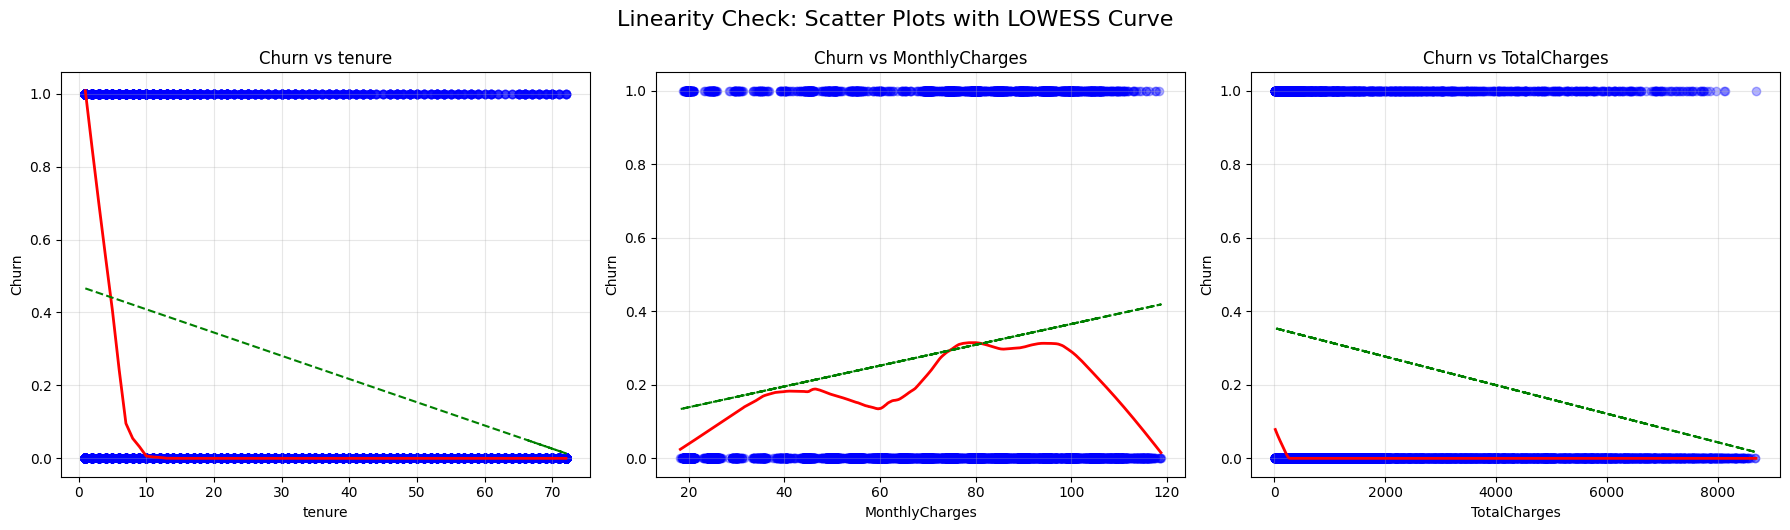


Ramsey's RESET Test Results (Manual Calculation):
F-statistic: 256.7095
p-value: 0.0000
Degrees of Freedom: 1, 7011.0
The RESET test indicates non-linear relationships in the model (p < 0.05).
Consider using transformations or non-linear models.


In [14]:
# Drop customerID as it's just an identifier
data = df.drop('customerID', axis=1)

# Scatter plots of continuous predictors vs. churn
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

for i, var in enumerate(continuous_vars):
    axes[i].scatter(data[var], data['Churn'], alpha=0.3, color='blue')

    # Add lowess smoother to help identify non-linearity
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lowess_result = lowess(data['Churn'], data[var], frac=0.3)
    axes[i].plot(lowess_result[:, 0], lowess_result[:, 1], 'r-', linewidth=2)

    # Add linear regression line for comparison
    x = data[var]
    y = data['Churn']
    coef = np.polyfit(x, y, 1)
    axes[i].plot(x, coef[0] * x + coef[1], 'g--', linewidth=1.5)

    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Churn')
    axes[i].set_title(f'Churn vs {var}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Linearity Check: Scatter Plots with LOWESS Curve', y=1.05, fontsize=16)
plt.show()

# Ramsey's RESET Test - Corrected approach
# Create formula including all variables except customerID
X_vars = [col for col in data.columns if col != 'Churn']
formula = 'Churn ~ ' + ' + '.join(X_vars)

# Fit OLS model
model = ols(formula, data=data).fit()

# Manual implementation of RESET test
# Add powers of fitted values to the model
data['fitted_values'] = model.fittedvalues
data['fitted_values_squared'] = model.fittedvalues**2

# Create new model with squared fitted values
reset_formula = formula + ' + fitted_values_squared'
reset_model = ols(reset_formula, data=data).fit()

# Get F-test results comparing the two models
from scipy import stats
df1 = 1  # number of restrictions
df2 = model.df_resid - 1  # degrees of freedom of restricted model

# Calculate F-statistic
f_stat = ((model.ssr - reset_model.ssr) / df1) / (reset_model.ssr / reset_model.df_resid)

# Calculate p-value
p_value = 1 - stats.f.cdf(f_stat, df1, df2)

print("\nRamsey's RESET Test Results (Manual Calculation):")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of Freedom: {df1}, {df2}")

if p_value < 0.05:
    print("The RESET test indicates non-linear relationships in the model (p < 0.05).")
    print("Consider using transformations or non-linear models.")
else:
    print("The RESET test does not detect significant non-linear relationships (p >= 0.05).")

# Clean up the added columns
data = data.drop(['fitted_values', 'fitted_values_squared'], axis=1)

### Independence of Observations Assumption Check for Linear Regression

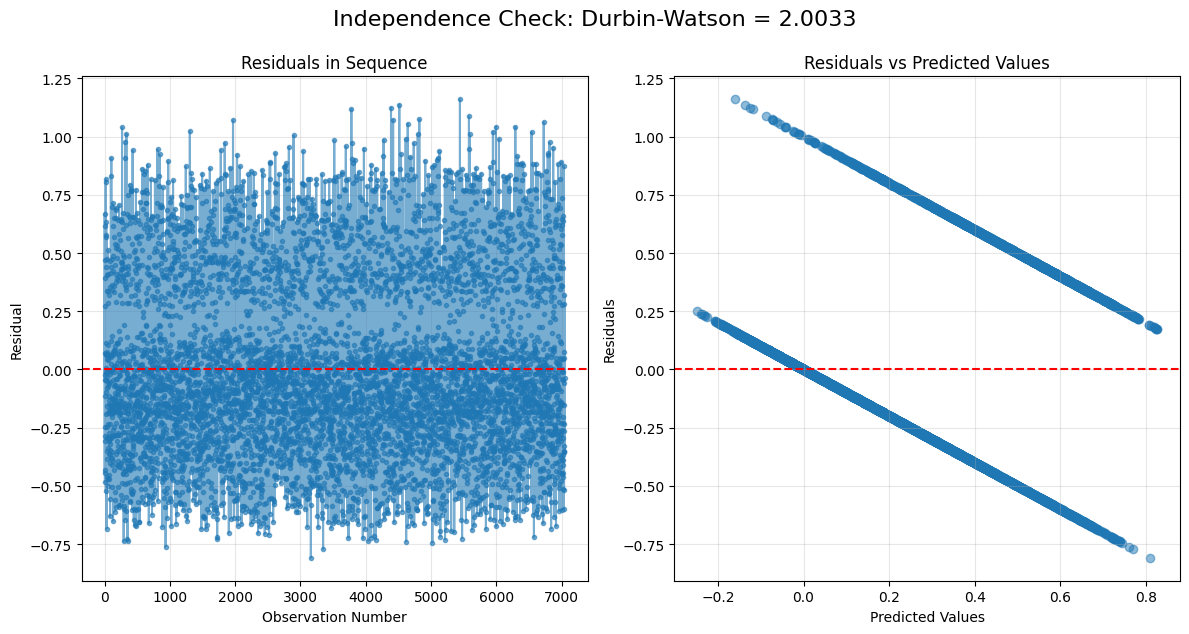


Durbin-Watson Statistic: 2.0033
Interpretation:
No significant autocorrelation detected (1.5 < DW < 2.5)


In [15]:
# Fit a model to get residuals
X = data.drop('Churn', axis=1)
y = data['Churn']
X = sm.add_constant(X)  # Add constant term
model = sm.OLS(y, X).fit()
residuals = model.resid

# Durbin-Watson test
dw_statistic = durbin_watson(residuals)

plt.figure(figsize=(12, 6))

# Plot residuals in sequence
plt.subplot(1, 2, 1)
plt.plot(residuals, 'o-', markersize=3, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals in Sequence')
plt.xlabel('Observation Number')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

# Plot residuals against predicted values
plt.subplot(1, 2, 2)
plt.scatter(model.fittedvalues, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Independence Check: Durbin-Watson = {dw_statistic:.4f}', y=1.05, fontsize=16)
plt.show()

print(f"\nDurbin-Watson Statistic: {dw_statistic:.4f}")
print("Interpretation:")
if dw_statistic < 1.5:
    print("Positive autocorrelation might be present (DW < 1.5)")
elif dw_statistic > 2.5:
    print("Negative autocorrelation might be present (DW > 2.5)")
else:
    print("No significant autocorrelation detected (1.5 < DW < 2.5)")

### Homoscedasticifty Assumption Check for Linear Regression

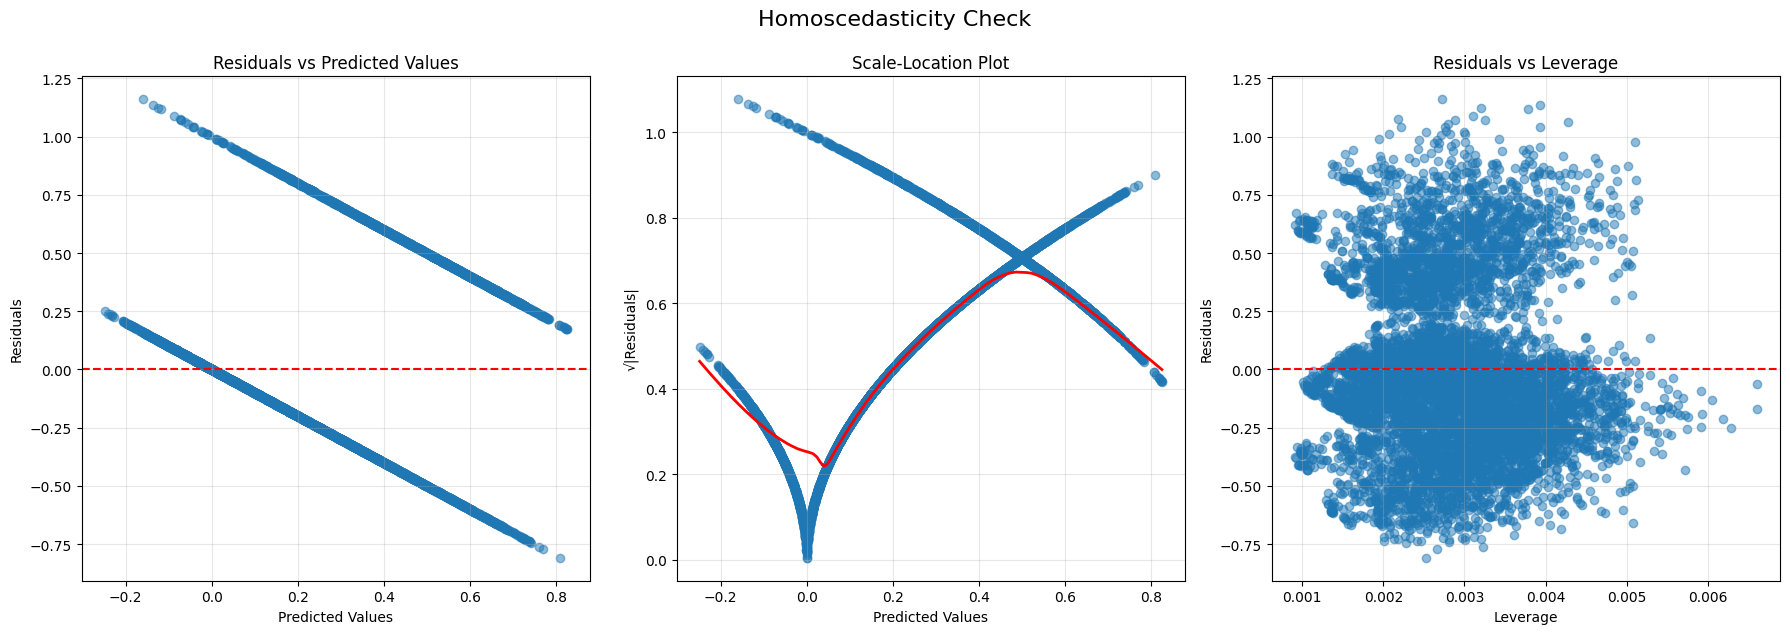


Breusch-Pagan Test Results:
LM Statistic: 1386.2445
p-value: 0.0000
F-statistic: 90.6162
F p-value: 0.0000
The Breusch-Pagan test indicates heteroscedasticity (p < 0.05).
Consider using robust standard errors or transforming variables.


In [16]:
# Breusch-Pagan test for heteroscedasticity
bp_test = diag.het_breuschpagan(residuals, X)

plt.figure(figsize=(18, 6))

# Residuals vs Predicted Values Plot
plt.subplot(1, 3, 1)
plt.scatter(model.fittedvalues, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Scale-Location Plot (Sqrt of abs residuals vs predicted values)
plt.subplot(1, 3, 2)
sqrt_abs_resid = np.sqrt(np.abs(residuals))
plt.scatter(model.fittedvalues, sqrt_abs_resid, alpha=0.5)
# Add a LOWESS smoother
lowess_result = lowess(sqrt_abs_resid, model.fittedvalues, frac=0.3)
plt.plot(lowess_result[:, 0], lowess_result[:, 1], 'r-', linewidth=2)
plt.title('Scale-Location Plot')
plt.xlabel('Predicted Values')
plt.ylabel('√|Residuals|')
plt.grid(True, alpha=0.3)

# Residuals vs Leverage
plt.subplot(1, 3, 3)
influence = model.get_influence()
leverage = influence.hat_matrix_diag
plt.scatter(leverage, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Homoscedasticity Check', y=1.05, fontsize=16)
plt.show()

print("\nBreusch-Pagan Test Results:")
print(f"LM Statistic: {bp_test[0]:.4f}")
print(f"p-value: {bp_test[1]:.4f}")
print(f"F-statistic: {bp_test[2]:.4f}")
print(f"F p-value: {bp_test[3]:.4f}")

if bp_test[1] < 0.05:
    print("The Breusch-Pagan test indicates heteroscedasticity (p < 0.05).")
    print("Consider using robust standard errors or transforming variables.")
else:
    print("The Breusch-Pagan test does not detect significant heteroscedasticity (p >= 0.05).")

### Normality of Residuals Assumption Check for Linear Regression

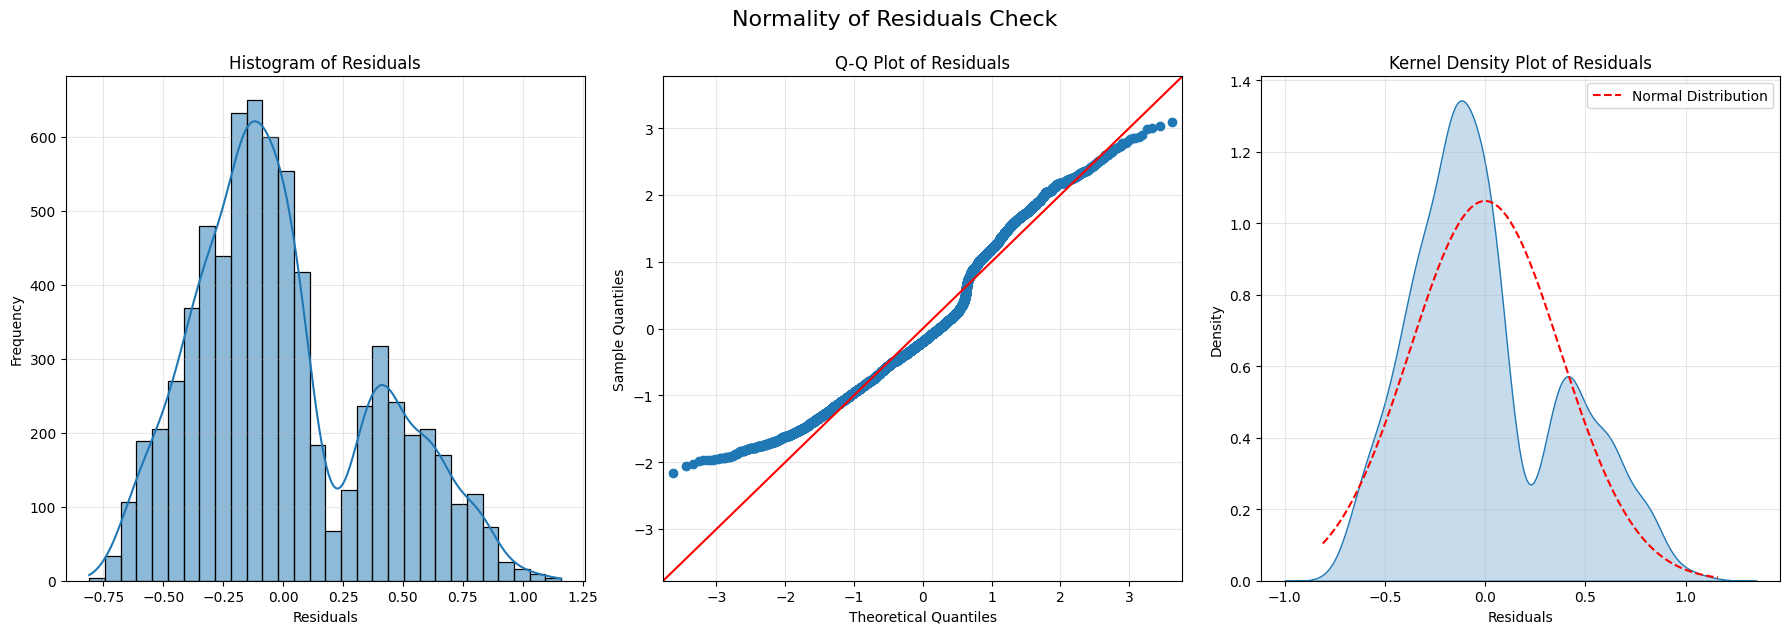


Shapiro-Wilk Test Results (on sample of 5000 observations):
W statistic: 0.9605
p-value: 0.0000
The Shapiro-Wilk test indicates that residuals are not normally distributed (p < 0.05).
Consider transforming variables or using robust regression methods.


In [17]:
plt.figure(figsize=(18, 6))

# Histogram of residuals
plt.subplot(1, 3, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Q-Q plot
plt.subplot(1, 3, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot of Residuals')
plt.grid(True, alpha=0.3)

# Kernel Density Plot
plt.subplot(1, 3, 3)
sns.kdeplot(residuals, fill=True)
# Add a normal distribution with same mean and std for comparison
x = np.linspace(min(residuals), max(residuals), 100)
plt.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()),
         'r--', label='Normal Distribution')
plt.title('Kernel Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Normality of Residuals Check', y=1.05, fontsize=16)
plt.show()

# Shapiro-Wilk test for normality
# Using a sample if there are too many observations (>5000)
if len(residuals) > 5000:
    residuals_sample = np.random.choice(residuals, size=5000, replace=False)
    shapiro_test = stats.shapiro(residuals_sample)
    print("\nShapiro-Wilk Test Results (on sample of 5000 observations):")
else:
    shapiro_test = stats.shapiro(residuals)
    print("\nShapiro-Wilk Test Results:")

print(f"W statistic: {shapiro_test[0]:.4f}")
print(f"p-value: {shapiro_test[1]:.4f}")

if shapiro_test[1] < 0.05:
    print("The Shapiro-Wilk test indicates that residuals are not normally distributed (p < 0.05).")
    print("Consider transforming variables or using robust regression methods.")
else:
    print("The Shapiro-Wilk test does not reject normality of residuals (p >= 0.05).")

### Multicollinearity Assumption Check for Linear Regression

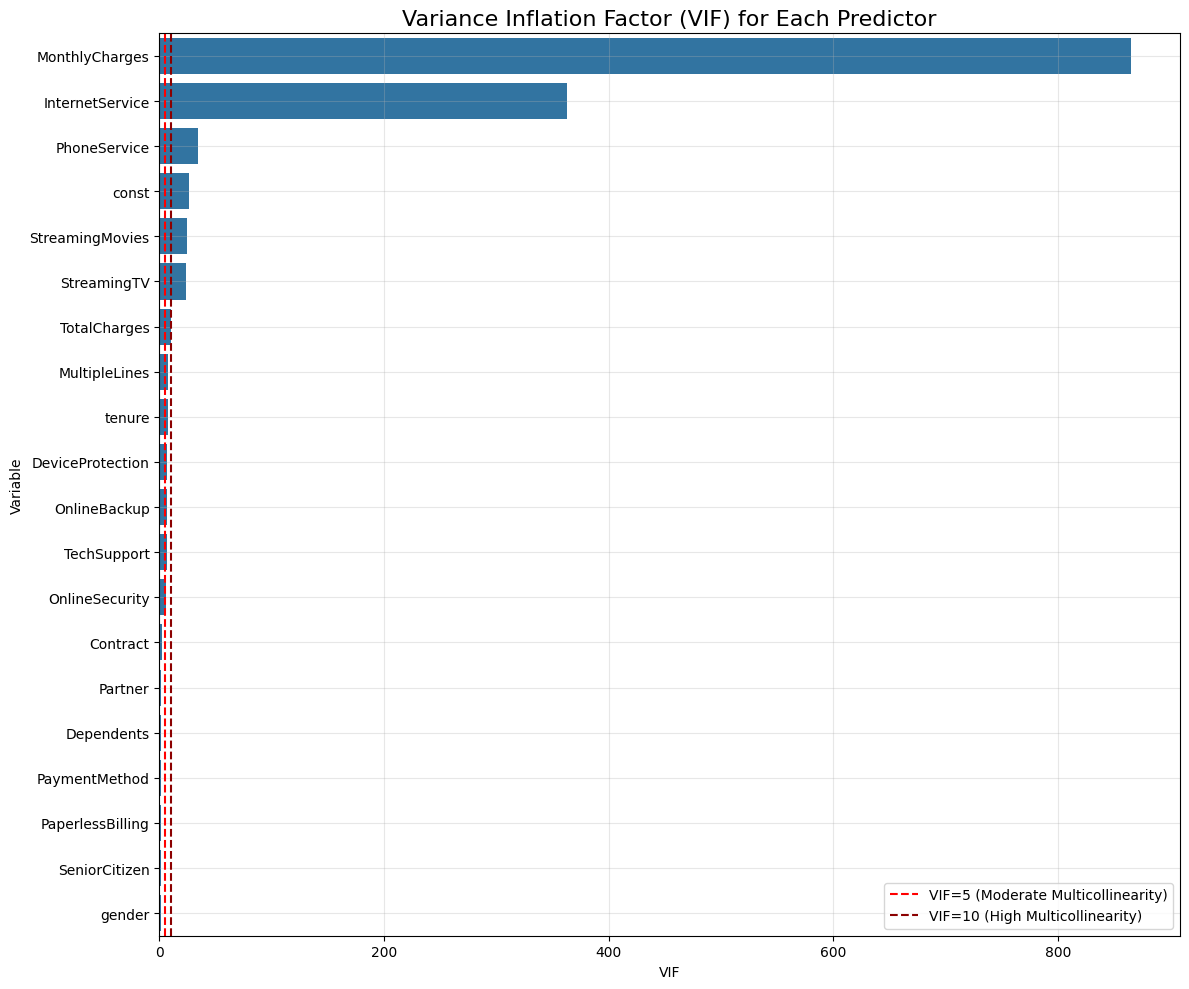


Variance Inflation Factor (VIF) Results:
            Variable         VIF
18    MonthlyCharges  865.576956
8    InternetService  363.359932
6       PhoneService   34.593773
0              const   26.438177
14   StreamingMovies   24.151566
13       StreamingTV   24.074812
19      TotalCharges   10.401509
7      MultipleLines    7.275447
5             tenure    7.257625
11  DeviceProtection    6.907313
10      OnlineBackup    6.767420
12       TechSupport    6.378194
9     OnlineSecurity    6.222924
15          Contract    2.464318
3            Partner    1.461260
4         Dependents    1.380229
17     PaymentMethod    1.218147
16  PaperlessBilling    1.201898
2      SeniorCitizen    1.149595
1             gender    1.001519

Interpretation:
VIF > 10: High multicollinearity
VIF > 5: Moderate multicollinearity
VIF < 5: Low multicollinearity


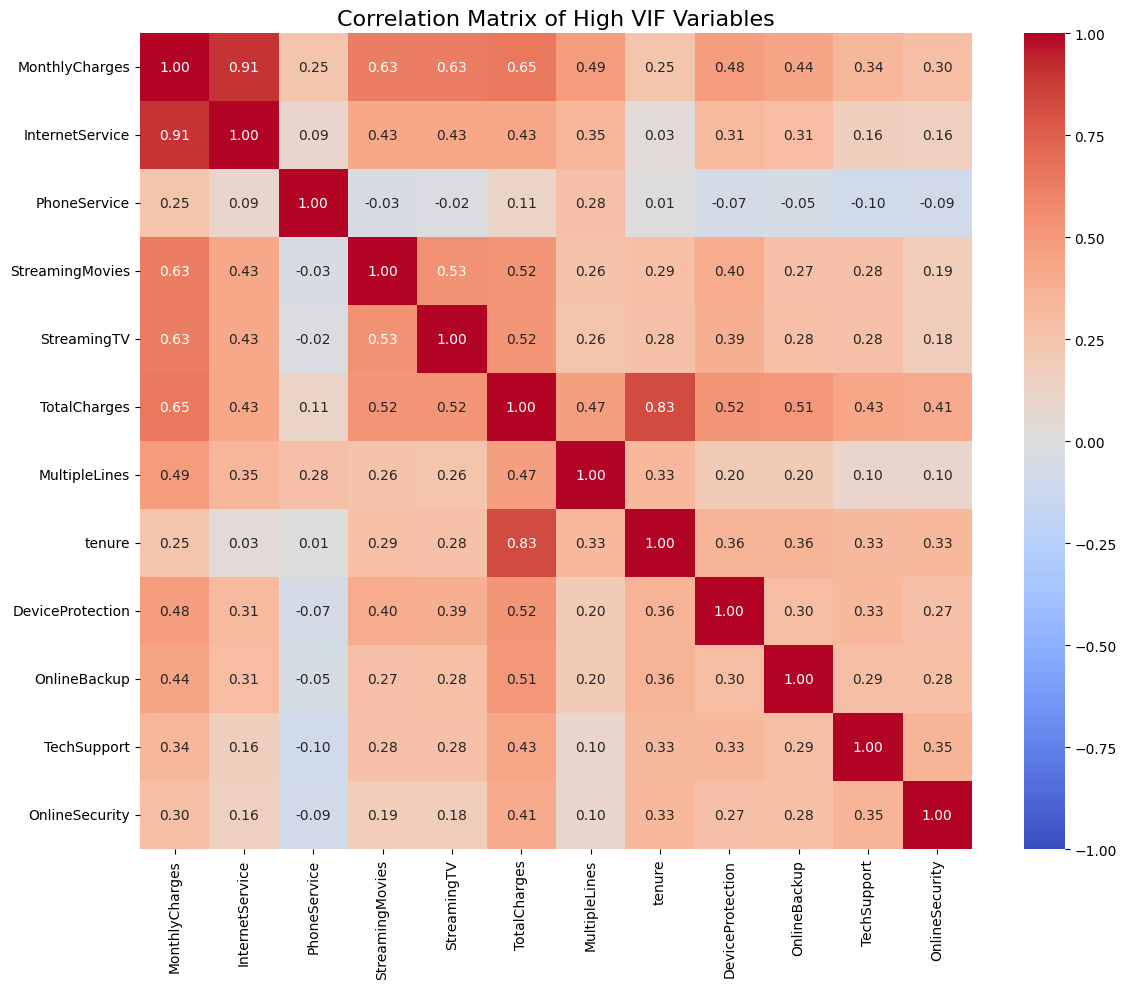

In [18]:
# Calculate VIF for each predictor
# VIF is calculated using all predictors, not just numerical ones
X = data.drop('Churn', axis=1)
X = sm.add_constant(X)  # Add constant term

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by VIF value
vif_data = vif_data.sort_values("VIF", ascending=False)

# Create a horizontal bar chart for VIF values
plt.figure(figsize=(12, 10))
sns.barplot(x="VIF", y="Variable", data=vif_data)
plt.title('Variance Inflation Factor (VIF) for Each Predictor', fontsize=16)
plt.axvline(x=5, color='r', linestyle='--', label='VIF=5 (Moderate Multicollinearity)')
plt.axvline(x=10, color='darkred', linestyle='--', label='VIF=10 (High Multicollinearity)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVariance Inflation Factor (VIF) Results:")
print(vif_data)
print("\nInterpretation:")
print("VIF > 10: High multicollinearity")
print("VIF > 5: Moderate multicollinearity")
print("VIF < 5: Low multicollinearity")

# Extract high VIF variables for correlation analysis
# Based on VIF results, these are the variables with highest VIF
high_vif_vars = ['MonthlyCharges', 'InternetService', 'PhoneService',
                 'StreamingMovies', 'StreamingTV', 'TotalCharges', 'MultipleLines',
                 'tenure', 'DeviceProtection', 'OnlineBackup', 'TechSupport', 'OnlineSecurity']

high_vif_corr = data[high_vif_vars].corr()

# Create a heatmap specifically for high VIF variables
plt.figure(figsize=(12, 10))
sns.heatmap(high_vif_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of High VIF Variables', fontsize=16)
plt.tight_layout()
plt.show()

# Add correlation values for highest VIF variables
top_vif_vars = vif_data.head(6)['Variable'].tolist()
if 'const' in top_vif_vars:
    top_vif_vars.remove('const')  # Remove constant term from correlation analysi

### Interpretation Linear Regression EDA Analysis

- **Non-Linearity**: The Ramsey's RESET test (p-value = 0.0000) strongly indicates non-linear relationships. When running linear regression we should consider applying transformations like log or polynomial terms to continuous variables (tenure, MonthlyCharges, TotalCharges)

- **Multicollinearity**: VIF results show multicollinearity, with higher correlation between **(monthly charges & internet service)** and **(total charges and tenure)**. Lasso regularization Or variable dropping/combination should help address this issue.

- **Non-Normality**: The Shapiro-Wilk test (p-value = 0.0000) shows that residuals aren't normally distributed. May indicate model is unfit, but could improve with above transformations.

- **Heteroscedasticity**: Heteroscedasticity was detected. May indicate model is unfit relative to Logistic Regression, but let's apply some of the above transformations and see if that improves.  

- **Remove Redundant Features**: Given multicollinearity, we should perform feature selection, potentially using methods like LASSO.

### Linearity Assumption Check for Logistic Regression

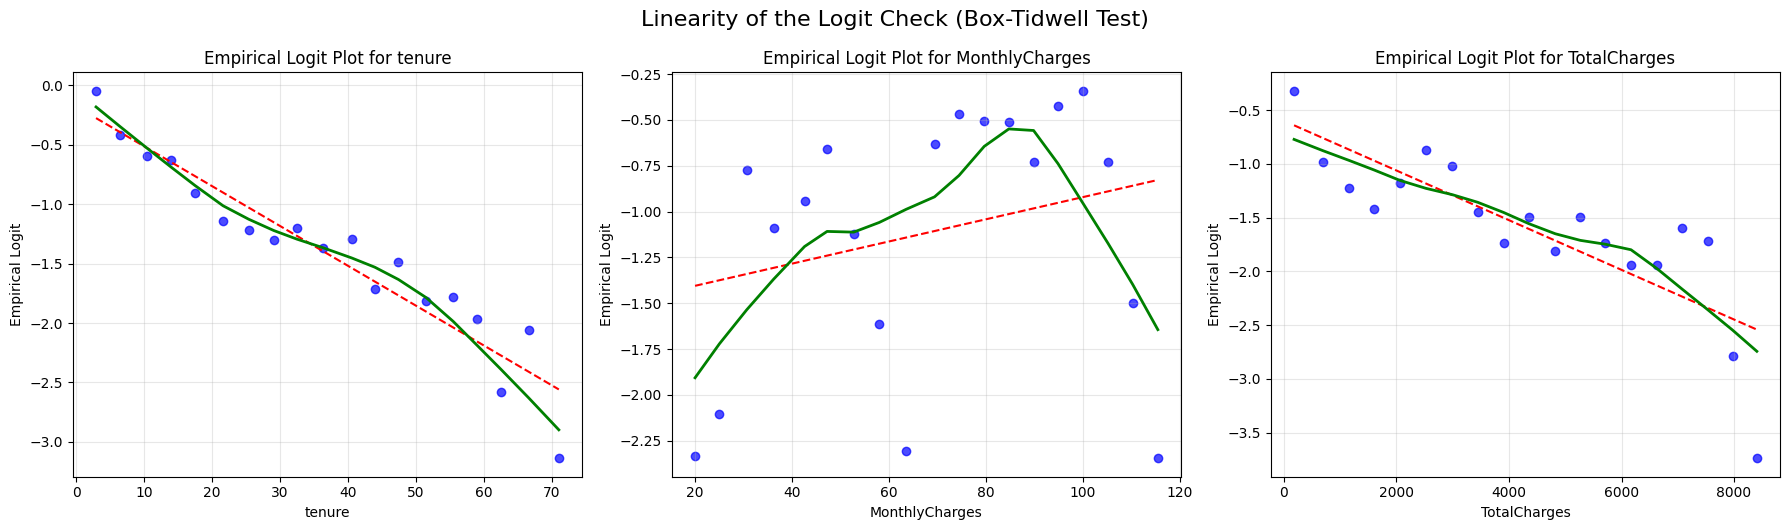

Box-Tidwell Test Results:
         Variable  Coefficient       p-value
0          tenure     0.018061  2.261831e-07
1  MonthlyCharges    -0.048641  2.570963e-26
2    TotalCharges     0.000249  1.444743e-15

Interpretation:
If p-value < 0.05, the linearity assumption is violated for that variable.
If the empirical logit plot shows curvature, consider transforming the variable.


In [19]:
# Drop customerID as it's just an identifier
data = df.drop('customerID', axis=1)

# Continuous predictors
continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a dataframe to store results
box_tidwell_results = pd.DataFrame(columns=['Variable', 'Coefficient', 'p-value'])

# Create a figure for visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, var in enumerate(continuous_vars):
    # Create interaction term (X * log(X))
    data[f'{var}_log'] = data[var] * np.log(data[var] + 1)  # Adding 1 to handle zeros

    # Fit logistic regression with variable and its interaction with log
    formula = f'Churn ~ {var} + {var}_log'
    model_bt = smf.logit(formula=formula, data=data).fit(disp=0)

    # Store results - using pandas concat instead of append
    new_row = pd.DataFrame({
        'Variable': [var],
        'Coefficient': [model_bt.params[f'{var}_log']],
        'p-value': [model_bt.pvalues[f'{var}_log']]
    })
    box_tidwell_results = pd.concat([box_tidwell_results, new_row], ignore_index=True)

    # Visualization: Plot empirical logit
    # Group data into bins
    bins = np.linspace(data[var].min(), data[var].max(), 20)
    groups = pd.cut(data[var], bins)

    # Calculate mean predictor and proportion of 1's in each bin
    bin_summary = data.groupby(groups, observed=False)[['Churn', var]].agg({
        'Churn': 'mean',
        var: 'mean'
    }).reset_index(drop=True)

    # Calculate empirical logit
    bin_summary['logit'] = np.log(bin_summary['Churn'] / (1 - bin_summary['Churn']))

    # Remove infinite values (if any)
    bin_summary = bin_summary.replace([np.inf, -np.inf], np.nan).dropna()

    # Plot empirical logit vs predictor
    axes[i].scatter(bin_summary[var], bin_summary['logit'], color='blue', alpha=0.7)

    # Add linear fit line
    if len(bin_summary) > 1:  # Ensure there are at least 2 points for regression
        x = bin_summary[var]
        y = bin_summary['logit']
        coef = np.polyfit(x, y, 1)
        axes[i].plot(x, coef[0] * x + coef[1], 'r--', linewidth=1.5)

    # Add smooth curve to check for non-linearity
    from statsmodels.nonparametric.smoothers_lowess import lowess
    if len(bin_summary) > 2:  # Need at least 3 points for lowess
        lowess_result = lowess(bin_summary['logit'], bin_summary[var], frac=0.6)
        axes[i].plot(lowess_result[:, 0], lowess_result[:, 1], 'g-', linewidth=2)

    axes[i].set_title(f'Empirical Logit Plot for {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Empirical Logit')
    axes[i].grid(True, alpha=0.3)

    # Clean up
    data = data.drop(f'{var}_log', axis=1)

plt.tight_layout()
plt.suptitle('Linearity of the Logit Check (Box-Tidwell Test)', y=1.05, fontsize=16)
plt.show()

# Display Box-Tidwell test results
print("Box-Tidwell Test Results:")
print(box_tidwell_results)
print("\nInterpretation:")
print("If p-value < 0.05, the linearity assumption is violated for that variable.")
print("If the empirical logit plot shows curvature, consider transforming the variable.")

### Complete Separation Assumption Check for Logistic Regression

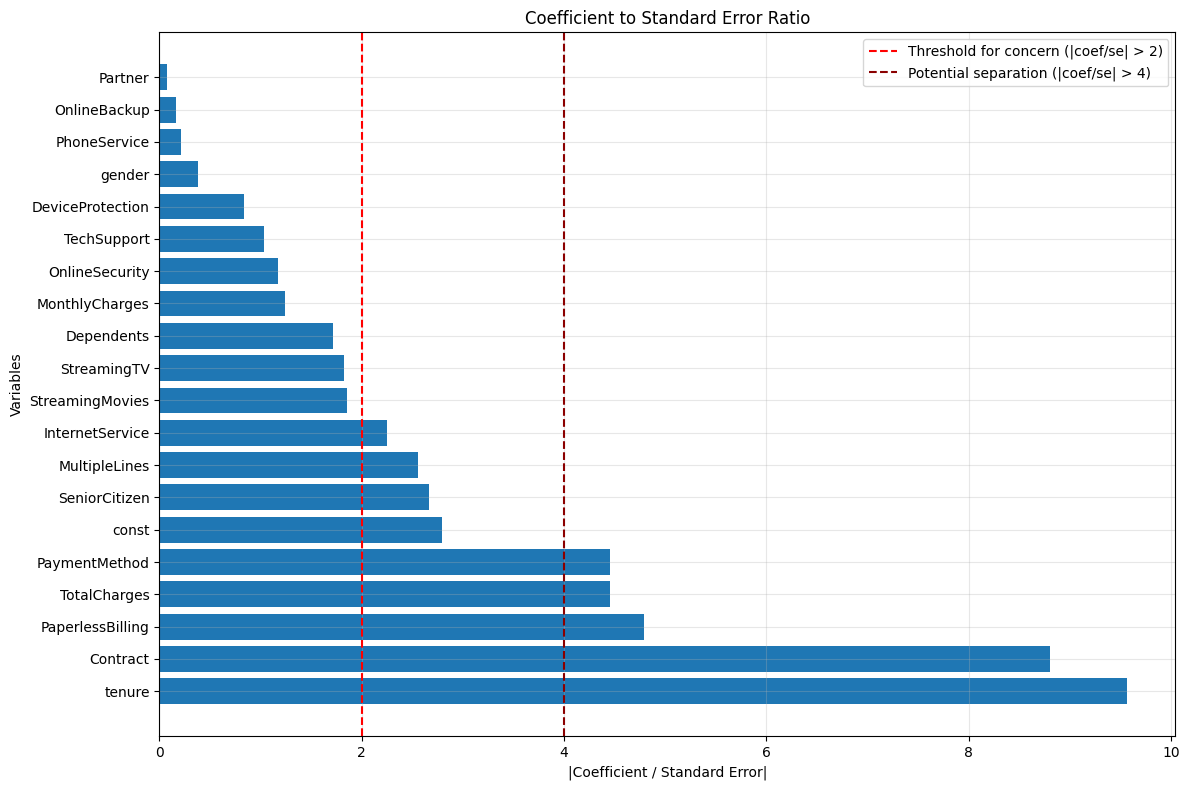

Logistic Regression Coefficient and Standard Error Results:
                  Coefficient  Std Error  |Coef/SE|
tenure              -0.058333   0.006097   9.567357
Contract            -0.679398   0.077189   8.801729
PaperlessBilling     0.355743   0.074255   4.790821
TotalCharges         0.000307   0.000069   4.456641
PaymentMethod       -0.134495   0.030184   4.455815
const               -0.447619   0.160170   2.794652
SeniorCitizen        0.225026   0.084423   2.665450
MultipleLines        0.452327   0.177218   2.552371
InternetService      1.789955   0.795952   2.248823
StreamingMovies      0.607283   0.326712   1.858773
StreamingTV          0.596504   0.326414   1.827444
Dependents          -0.153797   0.089633   1.715846
MonthlyCharges      -0.039558   0.031755   1.245752
OnlineSecurity      -0.209062   0.178143   1.173562
TechSupport         -0.186593   0.180112   1.035982
DeviceProtection     0.147034   0.176359   0.833721
gender              -0.024523   0.064740   0.378801
Phon

In [20]:
# Split data
X = data.drop('Churn', axis=1)
y = data['Churn']

# Add constant
X_sm = sm.add_constant(X)

# Fit full logistic regression model
try:
    logit_model = sm.Logit(y, X_sm).fit(disp=0)

    # Create a figure for visualization of separation
    plt.figure(figsize=(12, 8))

    # Extract parameters and standard errors
    params = logit_model.params
    std_errors = logit_model.bse

    # Calculate coefficient / standard error ratio
    ratio = abs(params / std_errors)

    # Sort for better visualization
    ratio = ratio.sort_values(ascending=False)

    # Create a bar plot
    plt.barh(range(len(ratio)), ratio, align='center')
    plt.yticks(range(len(ratio)), ratio.index)
    plt.axvline(x=2, color='r', linestyle='--',
                label='Threshold for concern (|coef/se| > 2)')
    plt.axvline(x=4, color='darkred', linestyle='--',
                label='Potential separation (|coef/se| > 4)')
    plt.title('Coefficient to Standard Error Ratio')
    plt.xlabel('|Coefficient / Standard Error|')
    plt.ylabel('Variables')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Display separation check results
    print("Logistic Regression Coefficient and Standard Error Results:")
    results_df = pd.DataFrame({
        'Coefficient': params,
        'Std Error': std_errors,
        '|Coef/SE|': abs(params / std_errors)
    }).sort_values('|Coef/SE|', ascending=False)

    print(results_df)
    print("\nInterpretation:")
    print("Very large coefficient to standard error ratios (e.g., > 4) may indicate separation.")
    print("Variables with extremely large ratios might perfectly or near-perfectly predict the outcome.")

    # Check for perfect prediction
    large_ratio_vars = results_df[results_df['|Coef/SE|'] > 4].index.tolist()
    if large_ratio_vars:
        print(f"\nPotential separation detected in variables: {', '.join(large_ratio_vars)}")
        print("Consider checking cross-tabulations for these variables.")
    else:
        print("\nNo strong indication of complete or quasi-complete separation.")

except Exception as e:
    print(f"Error in fitting model: {e}")
    print("This error might itself indicate complete separation.")

    # Try to identify problematic variables through individual analysis
    print("\nAttempting to identify problematic variables:")

    for col in X.columns:
        # Create a cross-tabulation
        cross_tab = pd.crosstab(data[col], data['Churn'])

        # Check for any zeros (indication of potential separation)
        if (cross_tab == 0).any().any():
            print(f"Variable '{col}' shows potential separation:")
            print(cross_tab)
            print()

### Calibration Check for Logistic Regression

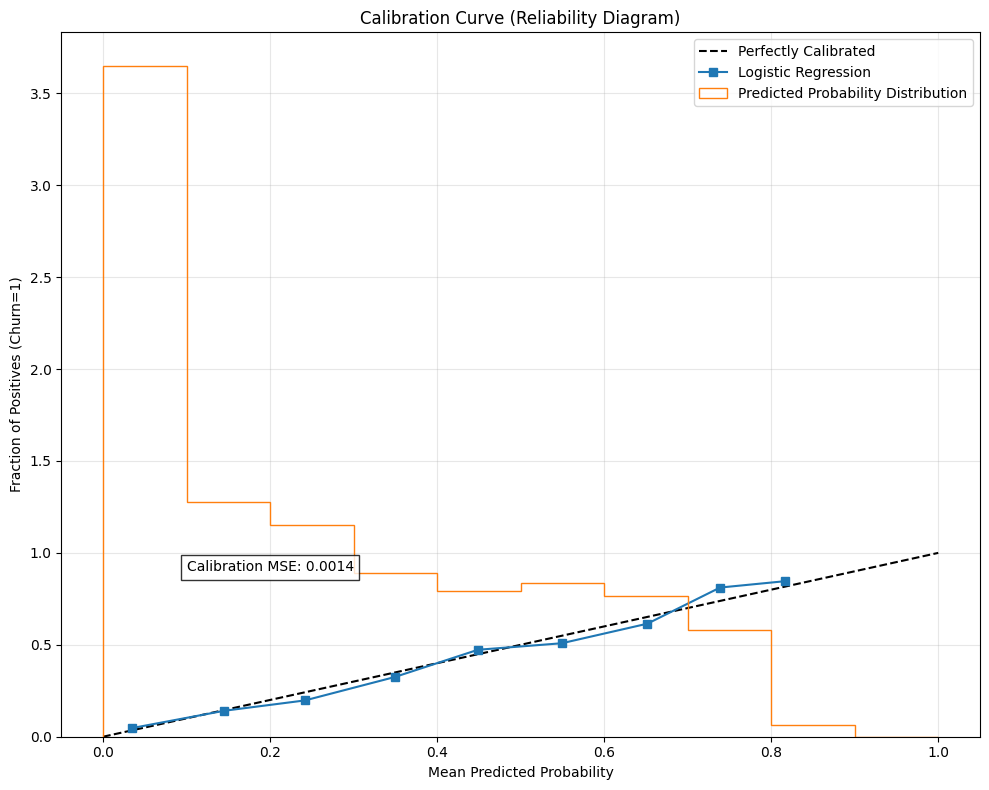

Calibration Check Results:
Calibration Mean Squared Error: 0.0014

Interpretation:
A well-calibrated model will follow the diagonal line (y=x).
Points above the line indicate underestimation of probabilities.
Points below the line indicate overestimation of probabilities.
Lower calibration MSE indicates better probability estimates.


In [21]:
# Drop customerID as it's just an identifier
data = df.drop('customerID', axis=1)

# Split data into training and testing sets
X = data.drop('Churn', axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Get predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Plot calibration curve
plt.figure(figsize=(10, 8))

# Plot perfectly calibrated curve
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

# Plot calibration curve for the model
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.plot(prob_pred, prob_true, 's-', label='Logistic Regression')

# Calculate MSE of the calibration curve
calibration_mse = np.mean((prob_true - prob_pred) ** 2)

# Add histograms for predicted probabilities - changed normed to density
plt.hist(y_pred_prob, range=(0, 1), bins=10, histtype='step',
         density=True, label='Predicted Probability Distribution')

plt.title('Calibration Curve (Reliability Diagram)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Churn=1)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Add calibration MSE to the plot
plt.text(0.1, 0.9, f'Calibration MSE: {calibration_mse:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("Calibration Check Results:")
print(f"Calibration Mean Squared Error: {calibration_mse:.4f}")
print("\nInterpretation:")
print("A well-calibrated model will follow the diagonal line (y=x).")
print("Points above the line indicate underestimation of probabilities.")
print("Points below the line indicate overestimation of probabilities.")
print("Lower calibration MSE indicates better probability estimates.")

### Sample Size Check for Logistic Regression

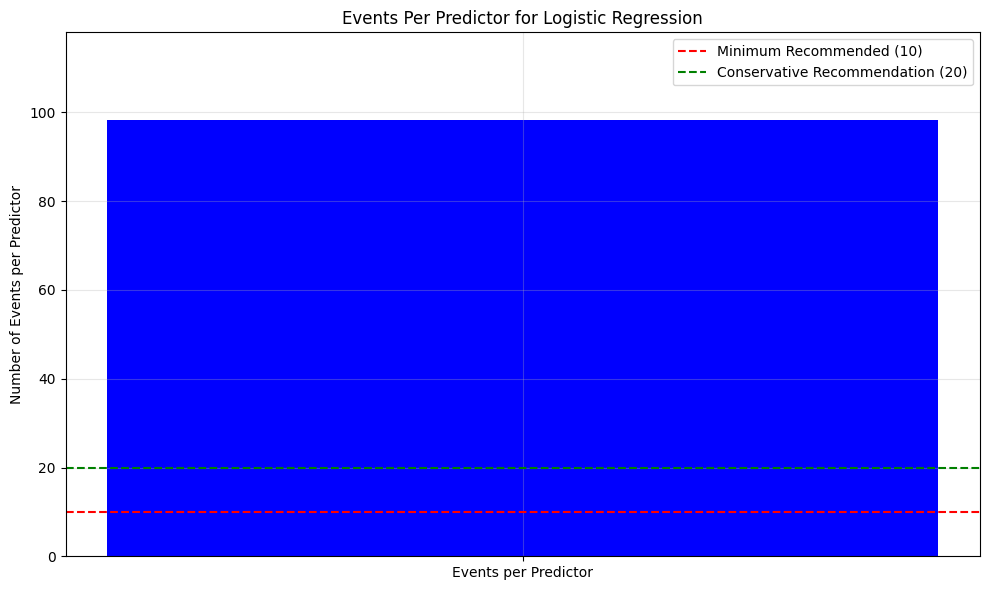

Adequate Sample Size Check Results:
Number of predictors: 19
Number of events (Churn=1): 1869
Events per predictor: 98.37

Interpretation:
EXCELLENT: More than 20 events per predictor (conservative recommendation).

Based on the number of events, the maximum recommended number of predictors is: 186

Variable Importance for Selection (if needed):
            Variable  Importance
5       PhoneService    0.760212
14          Contract    0.678800
7    InternetService    0.651973
8     OnlineSecurity    0.430065
11       TechSupport    0.410054
15  PaperlessBilling    0.353362
6      MultipleLines    0.222131
1      SeniorCitizen    0.220674
9       OnlineBackup    0.191046
13   StreamingMovies    0.151434
3         Dependents    0.147748
12       StreamingTV    0.140302
16     PaymentMethod    0.135718
10  DeviceProtection    0.071277
4             tenure    0.058008
0             gender    0.024103
17    MonthlyCharges    0.005793
18      TotalCharges    0.000304
2            Partner    0

In [22]:
# Calculate number of predictors (exclude Churn)
n_predictors = data.shape[1] - 1

# Count number of events (Churn=1)
n_events = data['Churn'].sum()

# Calculate events per predictor
events_per_predictor = n_events / n_predictors

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Events per Predictor'], [events_per_predictor], color='blue')
plt.axhline(y=10, color='r', linestyle='--', label='Minimum Recommended (10)')
plt.axhline(y=20, color='g', linestyle='--', label='Conservative Recommendation (20)')
plt.title('Events Per Predictor for Logistic Regression')
plt.ylabel('Number of Events per Predictor')
plt.ylim(0, max(30, events_per_predictor * 1.2))  # Set appropriate y-axis limit
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display results
print("Adequate Sample Size Check Results:")
print(f"Number of predictors: {n_predictors}")
print(f"Number of events (Churn=1): {n_events}")
print(f"Events per predictor: {events_per_predictor:.2f}")
print("\nInterpretation:")
if events_per_predictor >= 20:
    print("EXCELLENT: More than 20 events per predictor (conservative recommendation).")
elif events_per_predictor >= 10:
    print("GOOD: At least 10 events per predictor (minimum recommendation).")
else:
    print("CAUTION: Less than 10 events per predictor.")
    print("Consider reducing the number of predictors or collecting more data.")

# Additional calculation: Maximum number of predictors recommended
max_recommended_predictors = n_events / 10
print(f"\nBased on the number of events, the maximum recommended number of predictors is: {int(max_recommended_predictors)}")

# If using variable selection, show how many variables we can keep
print("\nVariable Importance for Selection (if needed):")
from sklearn.linear_model import LogisticRegression

X = data.drop('Churn', axis=1)
y = data['Churn']

# Fit logistic regression with L1 penalty to get feature importance
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
logreg_l1.fit(X, y)

# Get feature importance and sort
feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Importance': np.abs(logreg_l1.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Show top variables
print(feature_importance)

### Interpretation for Logistic Model Assumptions EDA

- **Linearity**: We should apply transformations to continuous variables *(tenure, MonthlyCharges, TotalCharges)* as Box-Tidwell test shows significant non-linearity (p<0.05); consider log transformations.

- **Multicollinearity**: Removing either *InternetService (VIF=363)* or *MonthlyCharges (VIF=864)* could be beneficial alongside also removing *StreamingTV and StreamingMovies (both VIF>24)* due to high collinearity.

- **Separation**: Some variables show high coefficient/standard error ratios *(tenure, Contract, PaperlessBilling, PaymentMethod, TotalCharges)*; Penalizing methods like Ridge could address address separation.

- **Feature Selection**: While sample size is adequate, L1 penalty results could help select select only the most important predictors, which increases model interpretability.  

### Non Linear Assumption Check for GAM

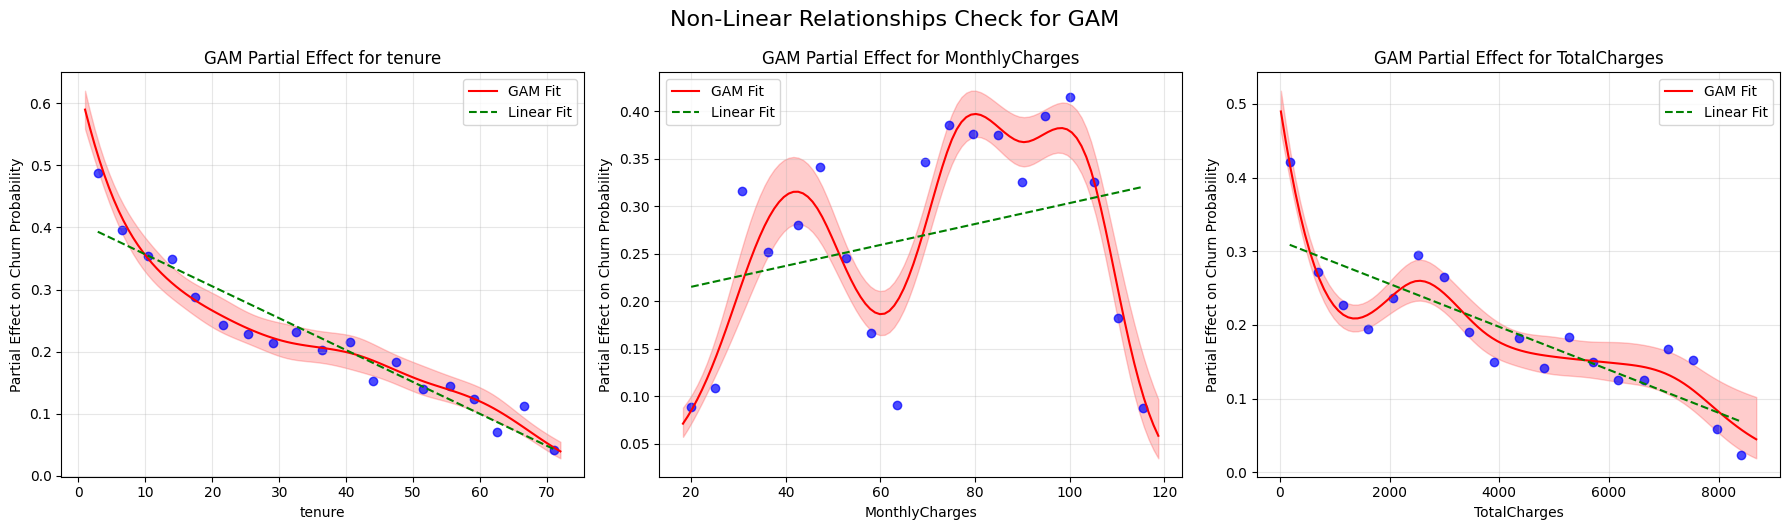

GAM Summary:
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     18.6242
Link Function:                        LogitLink Log Likelihood:                                 -3077.5125
Number of Samples:                         7032 AIC:                                             6192.2735
                                                AICc:                                            6192.3889
                                                UBRE:                                               2.8827
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2442
Feature Function        

In [23]:
# Continuous predictors
continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a figure for visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, var in enumerate(continuous_vars):
    # Create a feature matrix with just this predictor
    X = data[[var]].values
    y = data['Churn'].values

    # Fit a univariate GAM with a smooth term
    gam = LogisticGAM(s(0, n_splines=10, spline_order=3)).fit(X, y)

    # Generate prediction grid
    XX = np.linspace(X.min(), X.max(), 100)[:, np.newaxis]

    # Plot the partial effect
    axes[i].plot(XX[:, 0], gam.predict_proba(XX), 'r-', label='GAM Fit')

    # Add confidence intervals - FIXED HERE
    try:
        # Try the direct method first
        intervals = gam.confidence_intervals(XX, width=0.95)
        if isinstance(intervals, tuple) and len(intervals) == 2:
            lower, upper = intervals
            axes[i].fill_between(XX[:, 0], lower, upper, alpha=0.2, color='r')
        elif hasattr(intervals, 'shape') and intervals.shape[1] == 2:
            # Some versions return an array with shape (n, 2)
            axes[i].fill_between(XX[:, 0], intervals[:, 0], intervals[:, 1], alpha=0.2, color='r')
    except Exception as e:
        print(f"Skipping confidence intervals for {var}: {str(e)}")

    # Add scatter plot of binned data for comparison
    # Group data into bins
    bins = np.linspace(data[var].min(), data[var].max(), 20)
    groups = pd.cut(data[var], bins)

    # Calculate mean predictor and proportion of 1's in each bin
    bin_summary = data.groupby(groups, observed=False)[['Churn', var]].agg({
        'Churn': 'mean',
        var: 'mean'
    }).reset_index(drop=True)

    # Plot binned points
    axes[i].scatter(bin_summary[var], bin_summary['Churn'], color='blue', alpha=0.7)

    # Add a linear fit line for comparison
    if len(bin_summary) > 1:
        x = bin_summary[var]
        y = bin_summary['Churn']
        coef = np.polyfit(x, y, 1)
        axes[i].plot(x, coef[0] * x + coef[1], 'g--', linewidth=1.5, label='Linear Fit')

    axes[i].set_title(f'GAM Partial Effect for {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Partial Effect on Churn Probability')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Non-Linear Relationships Check for GAM', y=1.05, fontsize=16)
plt.show()

# Fit a multivariate GAM to test significance of smooth terms
# Prepare data
X = data[continuous_vars].values
y = data['Churn'].values

# Fit GAM
gam = LogisticGAM(s(0, n_splines=10) + s(1, n_splines=10) + s(2, n_splines=10)).fit(X, y)

# Display results
print("GAM Summary:")
print(gam.summary())
print("\nInterpretation:")
print("p-value < 0.05 for a smooth term indicates significant non-linearity.")
print("The shape of the partial effect plots shows the nature of the non-linear relationship.")

### Smoothing Parameters Assumption Check for GAM

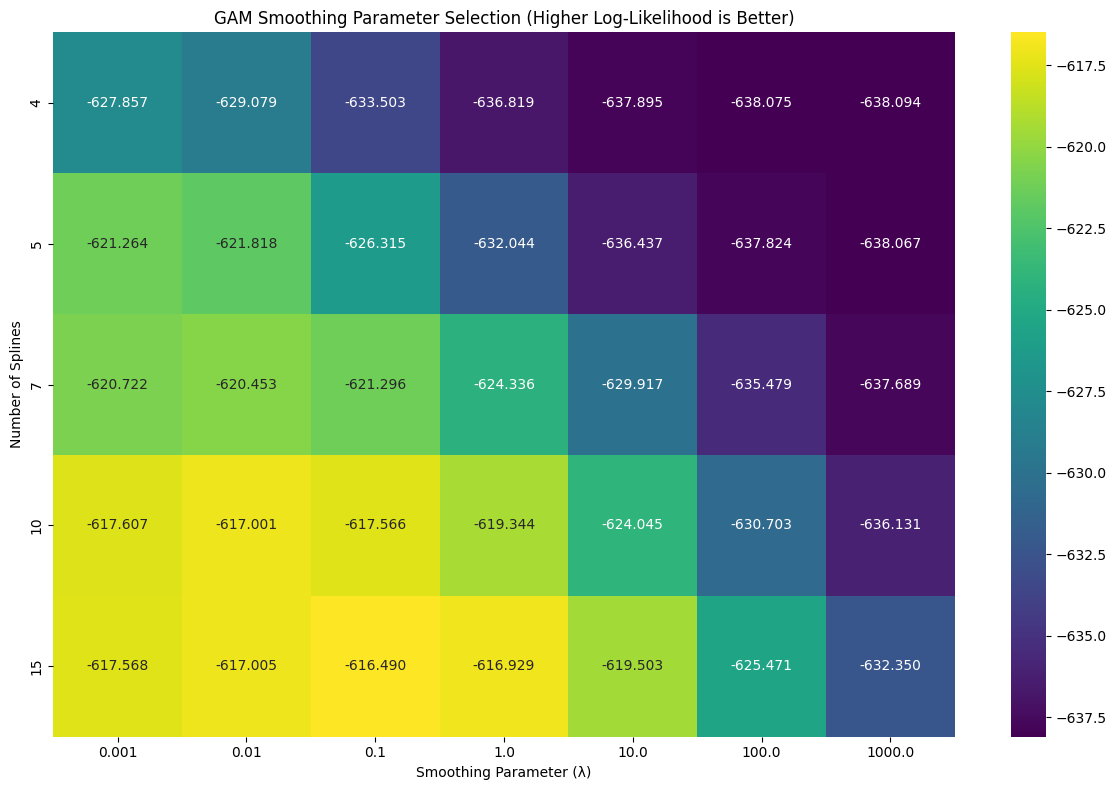

Best Smoothing Parameters:
Number of Splines: 15.0
Lambda (Smoothing Parameter): 0.1
Mean Log-Likelihood: -616.4901


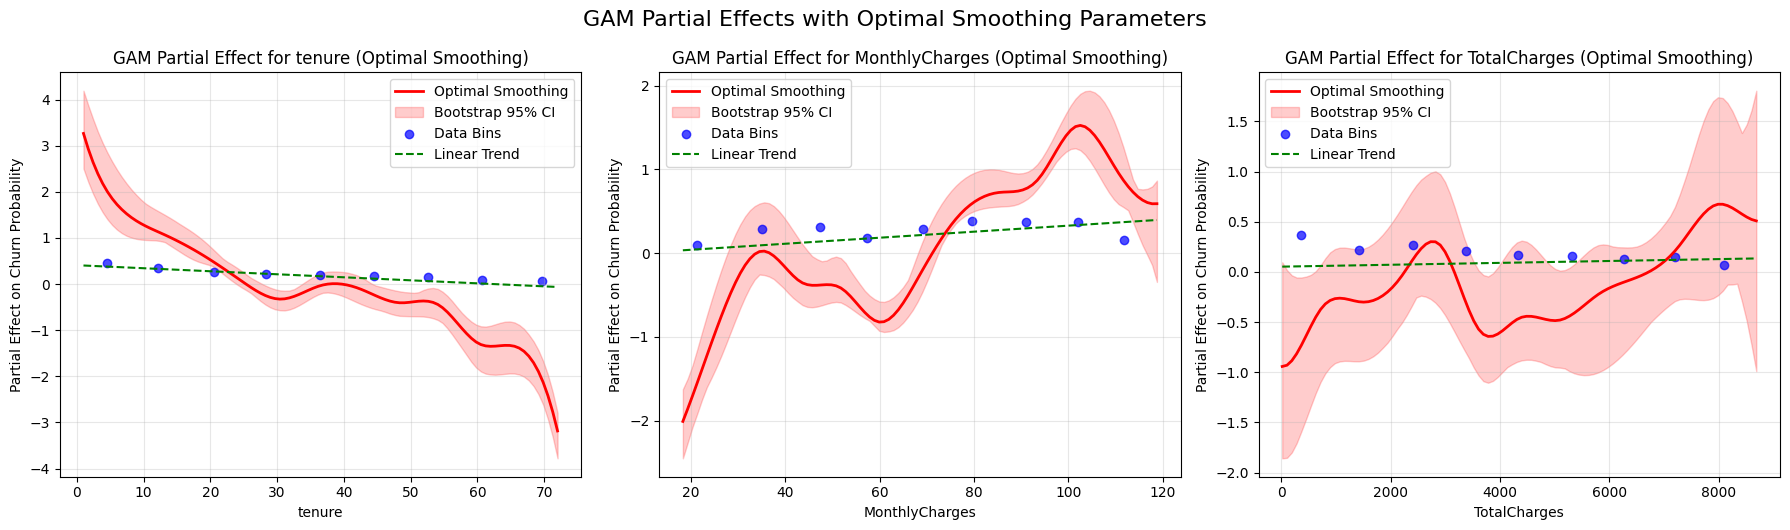


Best GAM Model Summary:
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     35.1726
Link Function:                        LogitLink Log Likelihood:                                  -3049.792
Number of Samples:                         7032 AIC:                                             6169.9294
                                                AICc:                                            6170.3138
                                                UBRE:                                               2.8814
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.251
Feature Func

In [24]:
# Ensure Churn is in binary format (0/1)
if data['Churn'].dtype == 'object':
    print("Converting Churn to binary format...")
    data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
    print(f"Unique values in Churn after conversion: {data['Churn'].unique()}")

# Set up cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Continuous predictors
continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Prepare data
X = data[continuous_vars].values
y = data['Churn'].values

# Try different smoothing parameters
lam_range = np.logspace(-3, 3, 7)  # Logarithmically spaced values
n_splines_range = [4, 5, 7, 10, 15]  # Changed from [3, 5, 7, 10, 15] to ensure n_splines > spline_order

# Store results
results = []

# For each number of splines
for n_splines in n_splines_range:
    # For each smoothing parameter
    for lam in lam_range:
        cv_scores = []

        # Cross-validation loop
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            try:
                # Fit GAM with current parameters
                gam = LogisticGAM(
                    s(0, n_splines=n_splines, spline_order=3, lam=lam) +
                    s(1, n_splines=n_splines, spline_order=3, lam=lam) +
                    s(2, n_splines=n_splines, spline_order=3, lam=lam)
                ).fit(X_train, y_train)

                # Evaluate on test set
                score = gam.loglikelihood(X_test, y_test)
                cv_scores.append(score)
            except Exception as e:
                print(f"Error with n_splines={n_splines}, lam={lam}: {e}")
                # Use a very low score to ensure this combination is not selected
                cv_scores.append(-np.inf)

        # Store average score
        results.append({
            'n_splines': n_splines,
            'lambda': lam,
            'mean_log_likelihood': np.mean(cv_scores)
        })

# Convert to DataFrame for easier handling
results_df = pd.DataFrame(results)

# Create a heatmap of results
plt.figure(figsize=(12, 8))
heatmap_data = results_df.pivot(index='n_splines', columns='lambda', values='mean_log_likelihood')
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='viridis')
plt.title('GAM Smoothing Parameter Selection (Higher Log-Likelihood is Better)')
plt.xlabel('Smoothing Parameter (λ)')
plt.ylabel('Number of Splines')
plt.tight_layout()
plt.show()

# Find best parameters
# Filter out -inf values first to avoid selecting errored combinations
valid_results = results_df[results_df['mean_log_likelihood'] > -np.inf]
if len(valid_results) > 0:
    best_result = valid_results.loc[valid_results['mean_log_likelihood'].idxmax()]
else:
    # Fallback to a reasonable default if all combinations failed
    best_result = pd.Series({'n_splines': 10, 'lambda': 0.1, 'mean_log_likelihood': -np.inf})

# Display best smoothing parameters
print("Best Smoothing Parameters:")
print(f"Number of Splines: {best_result['n_splines']}")
print(f"Lambda (Smoothing Parameter): {best_result['lambda']}")
print(f"Mean Log-Likelihood: {best_result['mean_log_likelihood']:.4f}")

# Fit model with best parameters
try:
    best_gam = LogisticGAM(
        s(0, n_splines=int(best_result['n_splines']), spline_order=3, lam=best_result['lambda']) +
        s(1, n_splines=int(best_result['n_splines']), spline_order=3, lam=best_result['lambda']) +
        s(2, n_splines=int(best_result['n_splines']), spline_order=3, lam=best_result['lambda'])
    ).fit(X, y)

    # Plot partial dependence with optimal smoothing
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, var in enumerate(continuous_vars):
        # Generate prediction grid
        XX = np.zeros((100, 3))
        XX[:, i] = np.linspace(X[:, i].min(), X[:, i].max(), 100)

        # Set other variables to their means
        for j in range(3):
            if j != i:
                XX[:, j] = X[:, j].mean()

        # Plot the partial effect
        pdep = best_gam.partial_dependence(term=i, X=XX)
        axes[i].plot(XX[:, i], pdep, 'r-', label='Optimal Smoothing', linewidth=2)

        # Alternative approach for confidence intervals using model.std_err_
        try:
            # Check if std_err_ attribute exists
            if hasattr(best_gam, 'std_err_'):
                # We can approximate confidence intervals using standard errors
                # and the shape of the partial dependence
                se = best_gam.std_err_
                # This is a simplified approach - in practice CIs are more complex
                # but this gives a rough visualization
                # Scale the std_err to make it visible on the plot
                scale_factor = 1.0
                pdep_se = np.std(pdep) * scale_factor

                axes[i].fill_between(
                    XX[:, i],
                    pdep - 1.96 * pdep_se,  # Approximate 95% CI
                    pdep + 1.96 * pdep_se,
                    alpha=0.2,
                    color='r',
                    label='Approx. 95% CI'
                )
            else:
                # Alternative - use bootstrap for a crude CI estimate
                # This is a simplified version for visualization purposes
                n_bootstrap = 10
                bootstrap_curves = []

                for _ in range(n_bootstrap):
                    # Create a bootstrap sample - sample with replacement
                    boot_idx = np.random.choice(len(X), size=len(X), replace=True)
                    X_boot, y_boot = X[boot_idx], y[boot_idx]

                    # Fit a model on the bootstrap sample
                    boot_gam = LogisticGAM(
                        s(0, n_splines=int(best_result['n_splines']), spline_order=3, lam=best_result['lambda']) +
                        s(1, n_splines=int(best_result['n_splines']), spline_order=3, lam=best_result['lambda']) +
                        s(2, n_splines=int(best_result['n_splines']), spline_order=3, lam=best_result['lambda'])
                    ).fit(X_boot, y_boot)

                    # Get partial dependence for this bootstrap
                    boot_pdep = boot_gam.partial_dependence(term=i, X=XX)
                    bootstrap_curves.append(boot_pdep)

                # Calculate confidence bounds from bootstrapped curves
                bootstrap_curves = np.array(bootstrap_curves)
                lower = np.percentile(bootstrap_curves, 2.5, axis=0)
                upper = np.percentile(bootstrap_curves, 97.5, axis=0)

                axes[i].fill_between(
                    XX[:, i],
                    lower,
                    upper,
                    alpha=0.2,
                    color='r',
                    label='Bootstrap 95% CI'
                )

        except Exception as e:
            print(f"Could not plot confidence intervals for {var} using alternative method: {e}")

        # Add a scatter plot of binned data for comparison
        try:
            # Group data into bins
            bins = np.linspace(data[var].min(), data[var].max(), 10)
            groups = pd.cut(data[var], bins)

            # Calculate mean predictor and proportion of 1's in each bin
            bin_summary = data.groupby(groups, observed=False)[['Churn', var]].agg({
                'Churn': 'mean',
                var: 'mean'
            }).reset_index(drop=True)

            # Plot binned points
            axes[i].scatter(bin_summary[var], bin_summary['Churn'], color='blue', alpha=0.7, label='Data Bins')
        except Exception as e:
            print(f"Could not plot binned data for {var}: {e}")

        # Add a linear fit line for comparison
        try:
            x_vals = XX[:, i]
            y_vals = best_gam.predict_proba(XX)

            # Simple linear fit for comparison
            coef = np.polyfit(x_vals, y_vals, 1)
            poly_fit = np.poly1d(coef)

            axes[i].plot(x_vals, poly_fit(x_vals), 'g--', linewidth=1.5, label='Linear Trend')
        except Exception as e:
            print(f"Could not plot linear trend for {var}: {e}")

        # Add a title and labels
        axes[i].set_title(f'GAM Partial Effect for {continuous_vars[i]} (Optimal Smoothing)')
        axes[i].set_xlabel(continuous_vars[i])
        axes[i].set_ylabel('Partial Effect on Churn Probability')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

    plt.tight_layout()
    plt.suptitle('GAM Partial Effects with Optimal Smoothing Parameters', y=1.05, fontsize=16)
    plt.show()

    # Print summary of the best model
    print("\nBest GAM Model Summary:")
    print(best_gam.summary())

    # Print interpretations
    print("\nInterpretation of Partial Effects:")
    for i, var in enumerate(continuous_vars):
        # Generate prediction grid for interpretation
        XX_interp = np.zeros((3, 3))
        XX_interp[:, i] = [X[:, i].min(), X[:, i].mean(), X[:, i].max()]

        # Set other variables to their means
        for j in range(3):
            if j != i:
                XX_interp[:, j] = X[:, j].mean()

        # Get predictions at min, mean, and max values
        pdep_interp = best_gam.partial_dependence(term=i, X=XX_interp)

        print(f"\n{var}:")
        print(f"  - At minimum value ({X[:, i].min():.2f}): Partial effect = {pdep_interp[0]:.4f}")
        print(f"  - At mean value ({X[:, i].mean():.2f}): Partial effect = {pdep_interp[1]:.4f}")
        print(f"  - At maximum value ({X[:, i].max():.2f}): Partial effect = {pdep_interp[2]:.4f}")

        # Direction of effect
        if pdep_interp[2] > pdep_interp[0]:
            print(f"  - Direction: Positive effect (higher {var} → higher probability of churn)")
        elif pdep_interp[2] < pdep_interp[0]:
            print(f"  - Direction: Negative effect (higher {var} → lower probability of churn)")
        else:
            print(f"  - Direction: No clear effect")

        # Non-linearity assessment
        mid_point = (pdep_interp[0] + pdep_interp[2]) / 2
        if abs(pdep_interp[1] - mid_point) < 0.01:
            print(f"  - Linearity: Effect appears approximately linear")
        else:
            print(f"  - Linearity: Effect shows non-linear behavior")

except Exception as e:
    print(f"Error fitting best model: {e}")
    print("Try running with different parameter combinations.")

### Concurvity Assumption Check for GAM

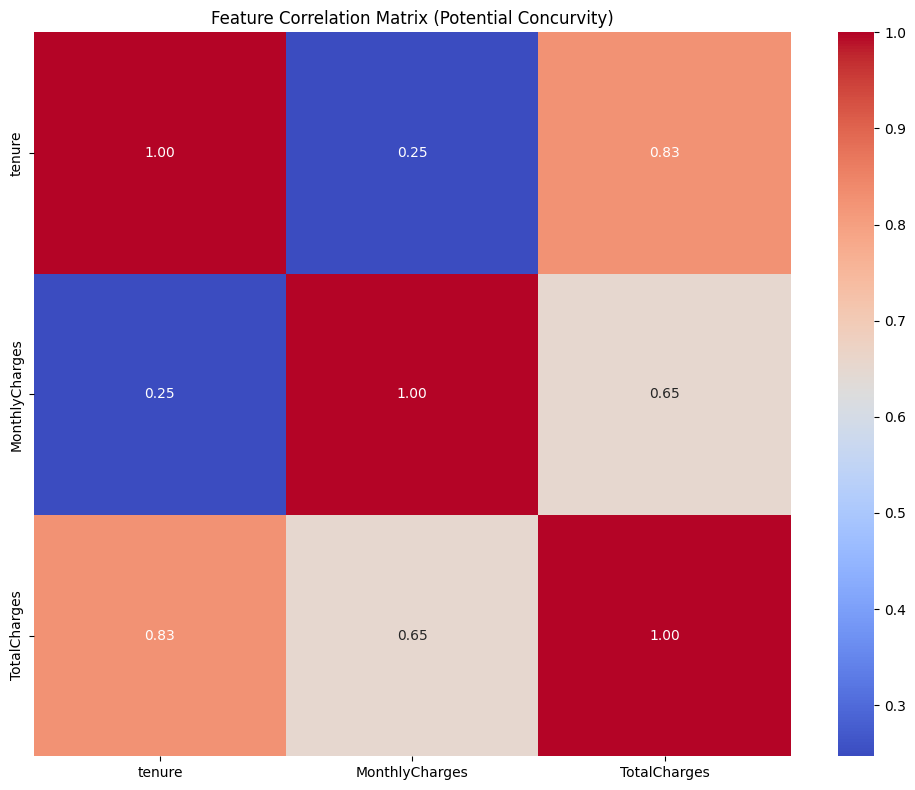

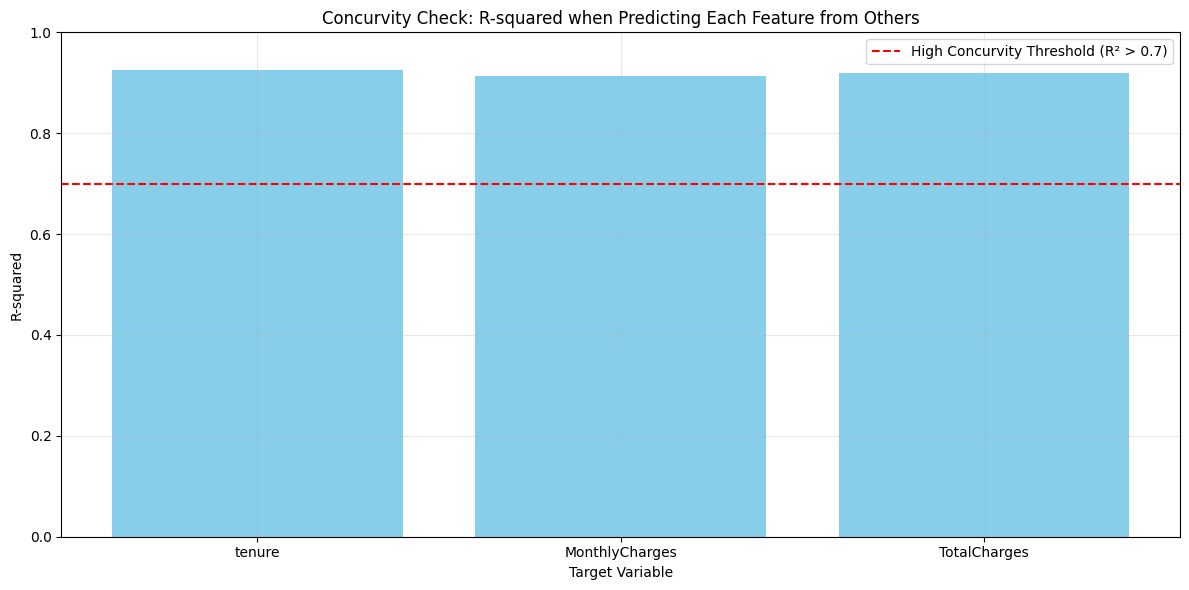

Concurvity Check Results:
           Target                    Predictors  R-squared
0          tenure  MonthlyCharges, TotalCharges   0.924486
1  MonthlyCharges          tenure, TotalCharges   0.912957
2    TotalCharges        tenure, MonthlyCharges   0.918446

Interpretation:
R-squared values close to 1 indicate high concurvity (similar to multicollinearity).
High concurvity can make it difficult to interpret individual smooth terms.
Consider removing or combining highly concurve variables.


In [25]:
# Continuous predictors
continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Prepare data
X = data[continuous_vars].values
y = data['Churn'].values

# Fit a multivariate GAM for the main model
gam = LogisticGAM(s(0, n_splines=10) + s(1, n_splines=10) + s(2, n_splines=10)).fit(X, y)

# Calculate pairwise correlations between features
corr_matrix = np.corrcoef(X, rowvar=False)

# Create a heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=continuous_vars, yticklabels=continuous_vars)
plt.title('Feature Correlation Matrix (Potential Concurvity)')
plt.tight_layout()
plt.show()

# Manual check for concurvity: Try to predict each feature from the others
concurvity_results = []

for i, target_var in enumerate(continuous_vars):
    # Variables to use as predictors
    predictor_vars = [var for var in continuous_vars if var != target_var]

    # Prepare data
    X_predictors = data[predictor_vars].values
    y_target = data[target_var].values

    # Standardize the target for easier interpretation
    y_target_std = (y_target - y_target.mean()) / y_target.std()

    # Fit a GAM (not LogisticGAM) to predict the continuous target variable
    try:
        # Use regular GAM instead of LogisticGAM for continuous prediction
        predictor_gam = GAM(s(0, n_splines=10) + s(1, n_splines=10)).fit(X_predictors, y_target_std)

        # Calculate R-squared as a measure of concurvity
        y_pred = predictor_gam.predict(X_predictors)
        ss_total = np.sum((y_target_std - y_target_std.mean()) ** 2)
        ss_residual = np.sum((y_target_std - y_pred) ** 2)
        r_squared = 1 - (ss_residual / ss_total)

        concurvity_results.append({
            'Target': target_var,
            'Predictors': ', '.join(predictor_vars),
            'R-squared': r_squared
        })
    except Exception as e:
        print(f"Error modeling {target_var}: {str(e)}")
        # Add a fallback result
        concurvity_results.append({
            'Target': target_var,
            'Predictors': ', '.join(predictor_vars),
            'R-squared': np.nan
        })

# Display concurvity results
concurvity_df = pd.DataFrame(concurvity_results)

# Handle any NaN values
concurvity_df = concurvity_df.fillna(0)

# Create a bar chart of R-squared values
plt.figure(figsize=(12, 6))
plt.bar(concurvity_df['Target'], concurvity_df['R-squared'], color='skyblue')
plt.axhline(y=0.7, color='r', linestyle='--', label='High Concurvity Threshold (R² > 0.7)')
plt.title('Concurvity Check: R-squared when Predicting Each Feature from Others')
plt.xlabel('Target Variable')
plt.ylabel('R-squared')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Concurvity Check Results:")
print(concurvity_df)
print("\nInterpretation:")
print("R-squared values close to 1 indicate high concurvity (similar to multicollinearity).")
print("High concurvity can make it difficult to interpret individual smooth terms.")
print("Consider removing or combining highly concurve variables.")

### Complexity and Performance Assumption Check for GAM

X shape: (7032, 19), y shape: (7032,)
Unique values in y: [0 1]
Available statistics for Linear Terms Only: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']
Available statistics for Small Splines (n=4): ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']
Available statistics for Medium Splines (n=7): ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']
Available statistics for Large Splines (n=15): ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']


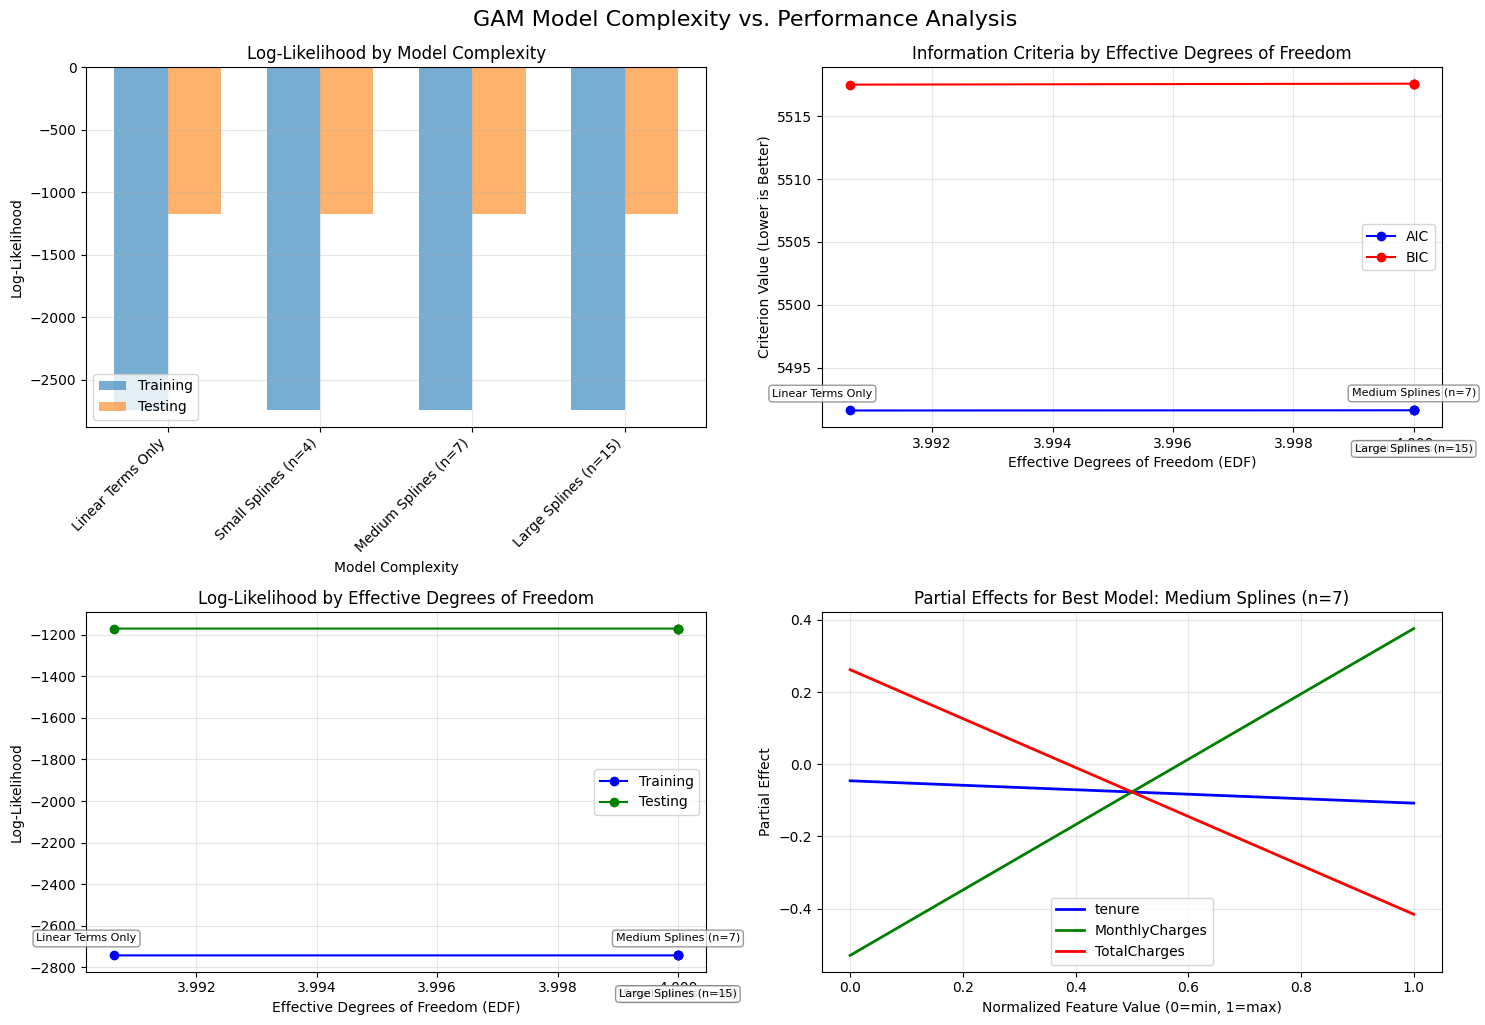

Model Complexity vs. Performance Results:
                   name  train_loglikelihood  test_loglikelihood          AIC  \
0     Linear Terms Only         -2741.798174        -1171.365939  5491.577623   
1   Small Splines (n=4)         -2741.796721        -1171.363249  5491.593442   
2  Medium Splines (n=7)         -2741.796721        -1171.363249  5491.593442   
3  Large Splines (n=15)         -2741.796721        -1171.363249  5491.593442   

           BIC       EDF  
0  5517.522631  3.990637  
1  5517.599323  4.000000  
2  5517.599323  4.000000  
3  5517.599323  4.000000  

Interpretation:
- The best model typically balances complexity (EDF) with performance.
- Look for the model with the lowest AIC/BIC or highest test log-likelihood.
- Best model based on test log-likelihood: Medium Splines (n=7)

Detailed observations:
- Models show different levels of complexity as measured by EDF.
- Testing log-likelihood is higher than training, which is unusual and may indicate data issues.
- 

In [26]:
# Ensure Churn is in binary format (0/1)
if data['Churn'].dtype == 'object':
    print("Converting Churn to binary format...")
    data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
    print(f"Unique values in Churn after conversion: {data['Churn'].unique()}")

# Prepare data
X = data.drop('Churn', axis=1).values
y = data['Churn'].values

# Print info about the data
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Unique values in y: {np.unique(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define different complexity levels for GAM
complexity_levels = [
    {
        'name': 'Linear Terms Only',
        'model': LogisticGAM(l(0) + l(1) + l(2)),
        'color': 'blue'
    },
    {
        'name': 'Small Splines (n=4)',
        'model': LogisticGAM(s(0, n_splines=4, spline_order=3) +
                            s(1, n_splines=4, spline_order=3) +
                            s(2, n_splines=4, spline_order=3)),
        'color': 'green'
    },
    {
        'name': 'Medium Splines (n=7)',
        'model': LogisticGAM(s(0, n_splines=7, spline_order=3) +
                            s(1, n_splines=7, spline_order=3) +
                            s(2, n_splines=7, spline_order=3)),
        'color': 'orange'
    },
    {
        'name': 'Large Splines (n=15)',
        'model': LogisticGAM(s(0, n_splines=15, spline_order=3) +
                            s(1, n_splines=15, spline_order=3) +
                            s(2, n_splines=15, spline_order=3)),
        'color': 'red'
    }
]

# Store results
results = []

# Train models with different complexities
for config in complexity_levels:
    try:
        model = config['model']
        model.fit(X_train, y_train)

        # Calculate metrics
        train_ll = model.loglikelihood(X_train, y_train)
        test_ll = model.loglikelihood(X_test, y_test)

        # Print available statistics keys for debugging
        print(f"Available statistics for {config['name']}: {list(model.statistics_.keys())}")

        # Safely get AIC and calculate BIC if not available
        aic = model.statistics_.get('AIC', None)

        # If AIC is not available, calculate it
        if aic is None:
            n = len(y_train)
            k = model.statistics_['edof']  # effective degrees of freedom
            aic = -2 * train_ll + 2 * k

        # Calculate BIC manually if not available
        # BIC = -2 * loglikelihood + log(n) * k
        n = len(y_train)
        k = model.statistics_['edof']  # effective degrees of freedom
        bic = -2 * train_ll + np.log(n) * k

        # Get effective degrees of freedom
        edf = model.statistics_['edof']

        results.append({
            'name': config['name'],
            'train_loglikelihood': train_ll,
            'test_loglikelihood': test_ll,
            'AIC': aic,
            'BIC': bic,
            'EDF': edf,
            'color': config['color']
        })
    except Exception as e:
        print(f"Error with model {config['name']}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

if len(results_df) > 0:
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training vs Testing Log-Likelihood
    bar_width = 0.35
    x = np.arange(len(results_df))
    axes[0, 0].bar(x - bar_width/2, results_df['train_loglikelihood'],
                width=bar_width, alpha=0.6, label='Training')
    axes[0, 0].bar(x + bar_width/2, results_df['test_loglikelihood'],
                width=bar_width, alpha=0.6, label='Testing')
    axes[0, 0].set_title('Log-Likelihood by Model Complexity')
    axes[0, 0].set_xlabel('Model Complexity')
    axes[0, 0].set_ylabel('Log-Likelihood')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(results_df['name'], rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # AIC and BIC
    axes[0, 1].plot(results_df['EDF'], results_df['AIC'], 'o-', color='blue', label='AIC')
    axes[0, 1].plot(results_df['EDF'], results_df['BIC'], 'o-', color='red', label='BIC')

    # Add labels with offset positions to avoid overlap
    for i, row in results_df.iterrows():
        # Add offset to position based on model name to avoid overlap
        y_offset = 10 if i % 2 == 0 else -30
        x_offset = -20 if i == 0 else 0  # Additional offset for first point

        axes[0, 1].annotate(row['name'],
                           (row['EDF'], row['AIC']),
                           textcoords="offset points",
                           xytext=(x_offset, y_offset),
                           ha='center',
                           fontsize=8,
                           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    axes[0, 1].set_title('Information Criteria by Effective Degrees of Freedom')
    axes[0, 1].set_xlabel('Effective Degrees of Freedom (EDF)')
    axes[0, 1].set_ylabel('Criterion Value (Lower is Better)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training vs Testing Log-Likelihood by EDF
    axes[1, 0].plot(results_df['EDF'], results_df['train_loglikelihood'], 'o-',
                    color='blue', label='Training')
    axes[1, 0].plot(results_df['EDF'], results_df['test_loglikelihood'], 'o-',
                    color='green', label='Testing')

    # Add labels with offset positions to avoid overlap
    for i, row in results_df.iterrows():
        # Add offset to position based on model name to avoid overlap
        y_offset = 10 if i % 2 == 0 else -30
        x_offset = -20 if i == 0 else 0  # Additional offset for first point

        axes[1, 0].annotate(row['name'],
                           (row['EDF'], row['train_loglikelihood']),
                           textcoords="offset points",
                           xytext=(x_offset, y_offset),
                           ha='center',
                           fontsize=8,
                           bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    axes[1, 0].set_title('Log-Likelihood by Effective Degrees of Freedom')
    axes[1, 0].set_xlabel('Effective Degrees of Freedom (EDF)')
    axes[1, 0].set_ylabel('Log-Likelihood')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot partial effects for model with best test log-likelihood
    best_idx = results_df['test_loglikelihood'].idxmax()
    best_model_name = results_df.loc[best_idx, 'name']
    best_model = complexity_levels[int(best_idx)]['model']

    # Create a better partial effects plot that doesn't use twinx
    try:
        continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
        colors = ['blue', 'green', 'red']

        # Create a single subplot for all three effects
        for i, var in enumerate([0, 1, 2]):
            # Generate prediction grid for this variable
            XX = np.zeros((100, X.shape[1]))
            XX[:, var] = np.linspace(X[:, var].min(), X[:, var].max(), 100)

            # Set other variables to their means
            for j in range(X.shape[1]):
                if j != var:
                    XX[:, j] = X[:, j].mean()

            # Normalize the x-axis for plotting
            x_values = (XX[:, var] - X[:, var].min()) / (X[:, var].max() - X[:, var].min())

            # Plot partial effect with normalized x-axis
            effect = best_model.partial_dependence(term=var, X=XX)
            axes[1, 1].plot(x_values, effect, '-',
                         label=continuous_vars[i], color=colors[i], linewidth=2)

        axes[1, 1].set_title(f'Partial Effects for Best Model: {best_model_name}')
        axes[1, 1].set_xlabel('Normalized Feature Value (0=min, 1=max)')
        axes[1, 1].set_ylabel('Partial Effect')
        axes[1, 1].legend(loc='best')
        axes[1, 1].grid(True, alpha=0.3)

    except Exception as e:
        print(f"Error plotting partial effects: {e}")
        axes[1, 1].text(0.5, 0.5, f"Error plotting partial effects: {str(e)}",
                        ha='center', va='center', transform=axes[1, 1].transAxes)

    plt.tight_layout()
    plt.suptitle('GAM Model Complexity vs. Performance Analysis', y=1.02, fontsize=16)
    plt.show()

    # Display results table
    print("Model Complexity vs. Performance Results:")
    print(results_df[['name', 'train_loglikelihood', 'test_loglikelihood', 'AIC', 'BIC', 'EDF']])
    print("\nInterpretation:")
    print("- The best model typically balances complexity (EDF) with performance.")
    print("- Look for the model with the lowest AIC/BIC or highest test log-likelihood.")
    print(f"- Best model based on test log-likelihood: {best_model_name}")

    # Add more detailed interpretation
    print("\nDetailed observations:")

    # Compare EDF values
    if results_df['EDF'].nunique() == 1:
        print("- All models have the same effective degrees of freedom (EDF), suggesting similar complexity.")
    else:
        print("- Models show different levels of complexity as measured by EDF.")

    # Look at likelihood differences
    ll_diff = results_df['train_loglikelihood'].max() - results_df['test_loglikelihood'].max()
    if abs(ll_diff) < 0.01:
        print("- Training and testing log-likelihoods are very similar, suggesting good generalization.")
    elif ll_diff > 0:
        print("- Training log-likelihood is higher than testing, suggesting some overfitting.")
    else:
        print("- Testing log-likelihood is higher than training, which is unusual and may indicate data issues.")

    # Compare AIC/BIC values
    aic_range = results_df['AIC'].max() - results_df['AIC'].min()
    if aic_range < 1:
        print("- Very small differences in AIC values suggest that models are similarly effective.")

    # Final recommendation
    best_aic_idx = results_df['AIC'].idxmin()
    best_aic_model = results_df.loc[best_aic_idx, 'name']

    if best_aic_model == best_model_name:
        print(f"- Both AIC and test log-likelihood agree that {best_model_name} is the best model.")
    else:
        print(f"- AIC suggests {best_aic_model} as the best model, while test log-likelihood suggests {best_model_name}.")
        print("- Consider your priorities: parsimony (AIC) or predictive performance (test log-likelihood).")
else:
    print("No models were successfully trained. Please check the errors above.")

### Interpretation for GAM Assumptions EDA

- **Concurvity**: continuous variables *(tenure, MonthlyCharges, TotalCharges)* show extremely high concurvity (R² > 0.91); This makes individual effects harder to interpret. removing TotalCharges might help while keeping monthly charges and tenure.

- **Simpler Model Structure**: The complexity analysis shows minimal performance differences between linear terms and spline models *(nearly identical AIC/BIC values)*, but this should consider simpler models limitations as well(Logistic and Lienar Models above)

- **Non-Linearity**: spline transformations needed for for *tenure (shows strong negative non-linear effect)* and *MonthlyCharges (shows positive non-linear effect)* to accurately obtain their relationships with dependent variable churn.

# Task 2

**Linear Regression: Treat the churn variable as a continuous variable (e.g., 0 for staying, 1 for churning) and build a linear regression model to predict churn. Interpret the coefficients and assess the model's performance.**


In [27]:
# print all column names
for column in df.columns:
    print(column)

customerID
gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn


In [28]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# X['log_tenure'] = np.log1p(X['tenure'])
X['log_TotalCharges'] = np.log1p(X['TotalCharges'])
X['log_MonthlyCharges'] = np.log1p(X['MonthlyCharges'])

# Removing Internet Services & Low explainability variables
X = X.drop(['InternetService', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'OnlineBackup', 'Partner', 'DeviceProtection', 'StreamingTV'], axis=1)
# X = X.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return model, y_pred

In [30]:
# Fit models
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")
#Show Accuracy
print(f"Linear Regression Accuracy: {accuracy_score(y_test, np.round(lr_pred)):.4f}")



Linear Regression:
MSE: 0.1451
R2 Score: 0.2567
Linear Regression Accuracy: 0.7854


In [31]:
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Churn   R-squared (uncentered):                   0.475
Model:                            OLS   Adj. R-squared (uncentered):              0.474
Method:                 Least Squares   F-statistic:                              529.8
Date:                Mon, 15 Sep 2025   Prob (F-statistic):                        0.00
Time:                        07:36:33   Log-Likelihood:                         -3051.8
No. Observations:                7032   AIC:                                      6128.
Df Residuals:                    7020   BIC:                                      6210.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

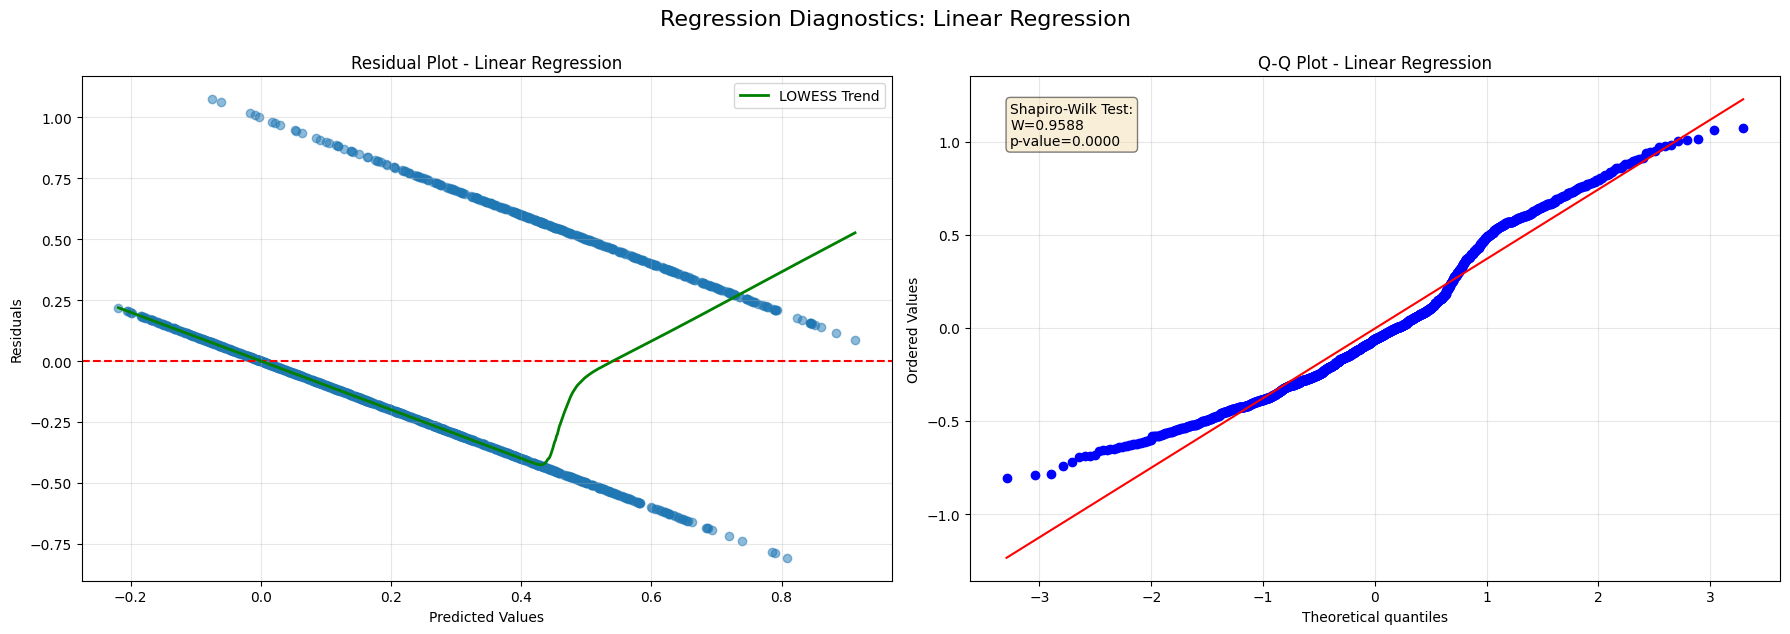


Diagnostic Statistics - Linear Regression:
Mean of Residuals: -0.0035
Standard Deviation of Residuals: 0.3808

Breusch-Pagan Test for Heteroscedasticity:
LM Statistic: 199.0076
p-value: 0.0000


In [32]:
def plot_regression_diagnostics(y_test, y_pred, model_name):
    residuals = y_test - y_pred

    # Create figure with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Residual Plot (left subplot)
    ax1.scatter(y_pred, residuals, alpha=0.5)
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title(f'Residual Plot - {model_name}')
    ax1.axhline(y=0, color='r', linestyle='--')

    # Add a LOWESS smoother to check for patterns
    lowess_result = lowess(residuals, y_pred, frac=0.6)
    ax1.plot(lowess_result[:, 0], lowess_result[:, 1], 'g-', linewidth=2, label='LOWESS Trend')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Q-Q Plot (right subplot)
    stats.probplot(residuals, plot=ax2)
    ax2.set_title(f'Q-Q Plot - {model_name}')
    ax2.grid(True, alpha=0.3)

    # Add statistical test results as text
    shapiro_test = stats.shapiro(residuals)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = '\n'.join((
        'Shapiro-Wilk Test:',
        f'W={shapiro_test[0]:.4f}',
        f'p-value={shapiro_test[1]:.4f}'
    ))
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.suptitle(f'Regression Diagnostics: {model_name}', y=1.05, fontsize=16)
    plt.show()

    # Additional statistics
    print(f"\nDiagnostic Statistics - {model_name}:")
    print(f"Mean of Residuals: {np.mean(residuals):.4f}")
    print(f"Standard Deviation of Residuals: {np.std(residuals):.4f}")

    # Heteroscedasticity test
    try:
        X_bp = sm.add_constant(y_pred)
        bp_test = het_breuschpagan(residuals, X_bp)
        print(f"\nBreusch-Pagan Test for Heteroscedasticity:")
        print(f"LM Statistic: {bp_test[0]:.4f}")
        print(f"p-value: {bp_test[1]:.4f}")

    except Exception as e:
        print(f"Could not perform heteroscedasticity test: {str(e)}")

# Example usage - only for Linear Regression
plot_regression_diagnostics(y_test, lr_pred, 'Linear Regression')

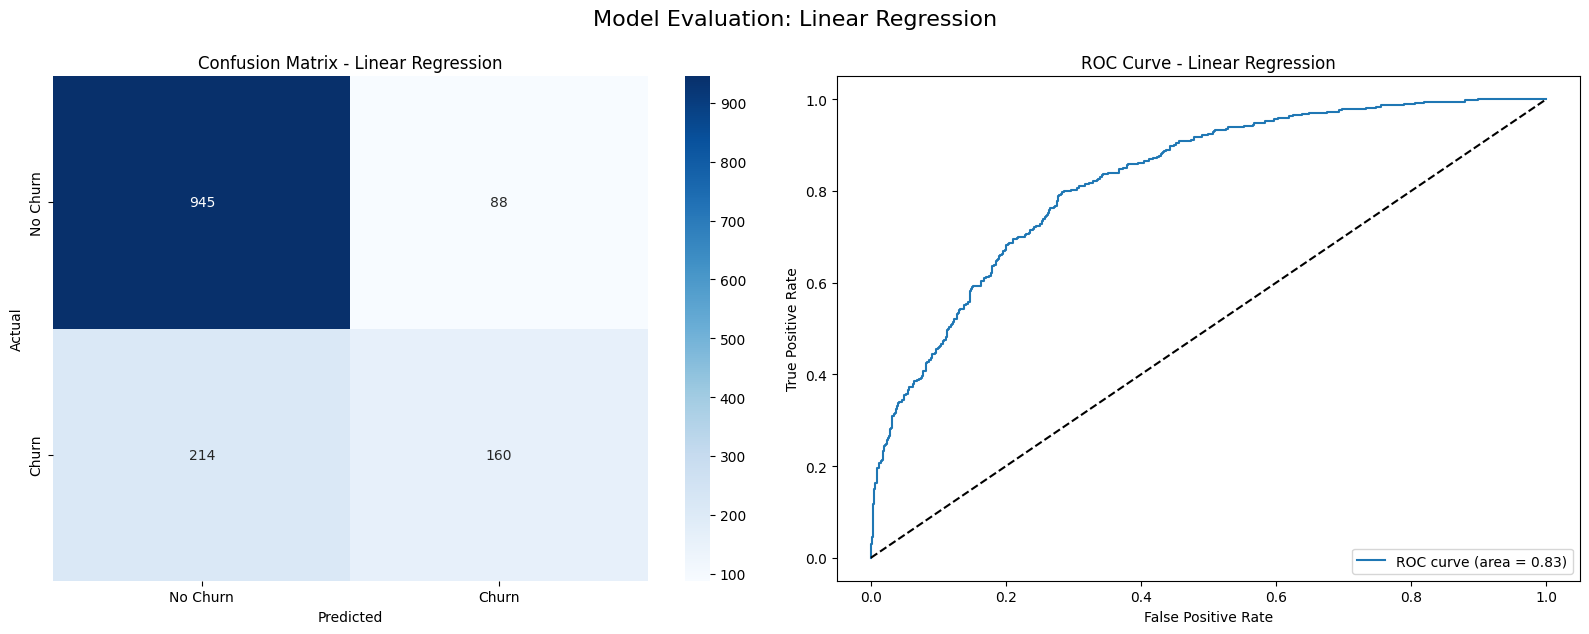

In [33]:
def plot_model_evaluation(y_true, y_pred, model_name):
    # Create a figure with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Confusion Matrix (left subplot)
    cm = confusion_matrix(y_true, np.round(y_pred))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Churn", "Churn"],
        yticklabels=["No Churn", "Churn"],
        ax=ax1
    )
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_title(f"Confusion Matrix - {model_name}")

    # ROC Curve (right subplot)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    ax2.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax2.plot([0, 1], [0, 1], "k--")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title(f"ROC Curve - {model_name}")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.suptitle(f"Model Evaluation: {model_name}", y=1.05, fontsize=16)
    plt.show()


    return roc_auc

# RPint ROC and COnfusion Matrix for Linear Regression
roc_auc_lr = plot_model_evaluation(y_test, lr_pred, "Linear Regression")

### Coefficient Interpretation Linear Regression

| Variable | Interpretation |
|----------|----------------|
| SeniorCitizen | Being a senior citizen increases the probability of churning by about 6.1%. This is statistically significant (p < 0.001), which means senior citizens are more likely to leave compared to non-seniors. |
| Dependents | Having dependents slightly decreases the likelihood of churning by 1.7%. However, this isn't statistically significant (p = 0.09), so we can't be confident that dependents actually impact churn rates. |
| PhoneService | Having phone service decreases churn probability by about 10.9%. This is highly significant (p < 0.001), suggesting customers with phone service are more loyal to the company. |
| MultipleLines | Customers with multiple lines are 5.6% more likely to churn. This effect is statistically significant (p < 0.001), which might indicate that customers with more complex services find more reasons to leave. |
| OnlineSecurity | Having online security decreases churn by 9.6%. This significant effect (p < 0.001) suggests that customers who feel their data is secure are more likely to stay with the company. |
| TechSupport | Tech support reduces churn probability by 9.5%. This significant effect (p < 0.001) indicates that customers who receive technical assistance are more satisfied and less likely to leave. |
| StreamingMovies | Customers with streaming movies are 2.5% more likely to churn. This is statistically significant (p = 0.019), though the effect is smaller than other services. |
| Contract | Each step up in contract length (from month-to-month to one year to two years) decreases churn by 5.2%. This significant effect (p < 0.001) shows longer contracts help retain customers. |
| PaperlessBilling | Customers with paperless billing are 5.6% more likely to churn. This significant effect (p < 0.001) might suggest these customers are more tech-savvy and willing to switch providers. |
| PaymentMethod | Each step up in payment method reduces churn probability by 2.5%. This significant effect (p < 0.001) suggests certain payment methods are associated with higher customer loyalty. |
| log_TotalCharges | A 1% increase in total charges is associated with a 0.11% decrease in churn probability. This highly significant effect (p < 0.001) suggests customers who have spent more with the company over time are less likely to leave. |
| log_MonthlyCharges | A 1% increase in monthly charges is associated with a 0.29% increase in churn probability. This highly significant effect (p < 0.001) shows that customers with higher monthly bills are much more likely to churn. |

### Linear Regression Model Results Interpretation
| Model Element | Interpretation |
|----------|----------------|
| ROC Score | A value of .83 indicates the model has a solid in predicting Churn |
| R^2 Test | A value of .2567 suggests the model performs just moderately on unseen data |
| R^2  | A value of .475 suggests the explains 47.5% of the variability in Churn |
| Accuracy  | An accuracy value of 78% suggests the there is value to implementing this model |
| Auto-Correlation  | After careful variable selection the model did not identify auto correlation with a Durbin Watson Score of 2.01 |
| Heteroscedasticity | The Breusch-Pagan Test for Heteroscedasticity(LM Statistic: 199.0076 p-value: 0.0000) suggests theere is Heteroscedasticity in residuals |
| Normality | The Shapiro-Wilk test result (W = 0.9588) indicates there could be a mild deviation from normality in the model residuals. This deviation is observed in the QQ plot where the blue dots slightly deviate from the red line at the tails indicating a relative skew on the data |


# Task 3
**Logistic Regression: Logistic Regression: Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.**

In [34]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# X['log_tenure'] = np.log1p(X['tenure'])
X['log_TotalCharges'] = np.log1p(X['TotalCharges'])
X['log_MonthlyCharges'] = np.log1p(X['MonthlyCharges'])

# Remove High VIF & Low explainability variables
X = X.drop(['InternetService', 'MonthlyCharges', 'TotalCharges', 'gender', 'OnlineBackup', 'Partner', 'DeviceProtection', 'StreamingTV', 'tenure'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.424740
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7020
Method:                           MLE   Df Model:                           11
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2665
Time:                        07:36:34   Log-Likelihood:                -2986.8
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
SeniorCitizen          0.3448      0.083      4.141      0.000       0.182       0.508
Depen

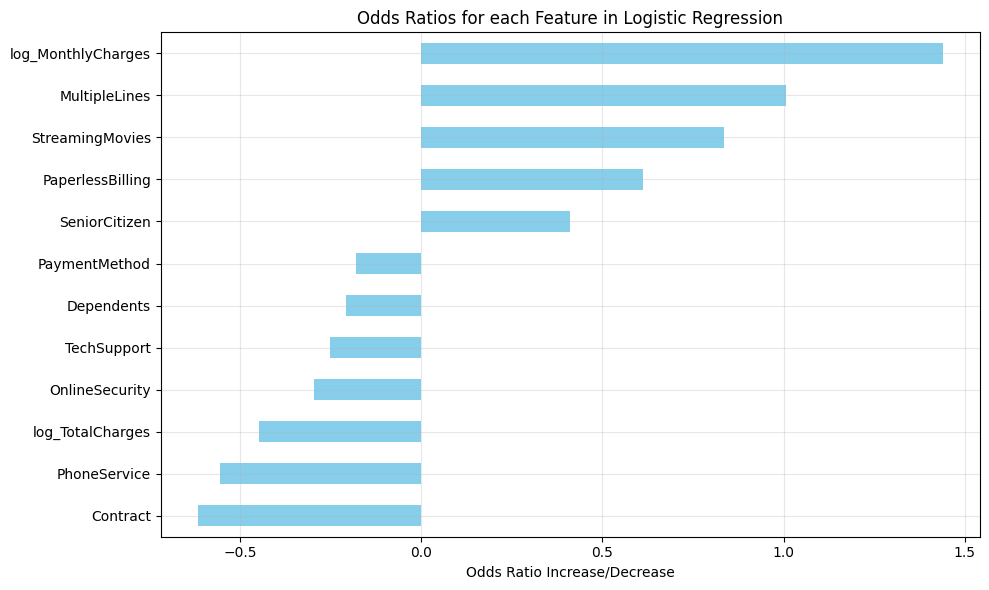

In [36]:
# print odds given coefficients of each variable showing increase and decrease in odds
odds_ratios = pd.Series(np.exp(logit_model.params) - 1, index=X.columns)

# Add them to bar charts displayed horizontally
plt.figure(figsize=(10, 6))
odds_ratios.sort_values().plot(kind='barh', color='skyblue')
plt.title('Odds Ratios for each Feature in Logistic Regression')
plt.xlabel('Odds Ratio Increase/Decrease')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

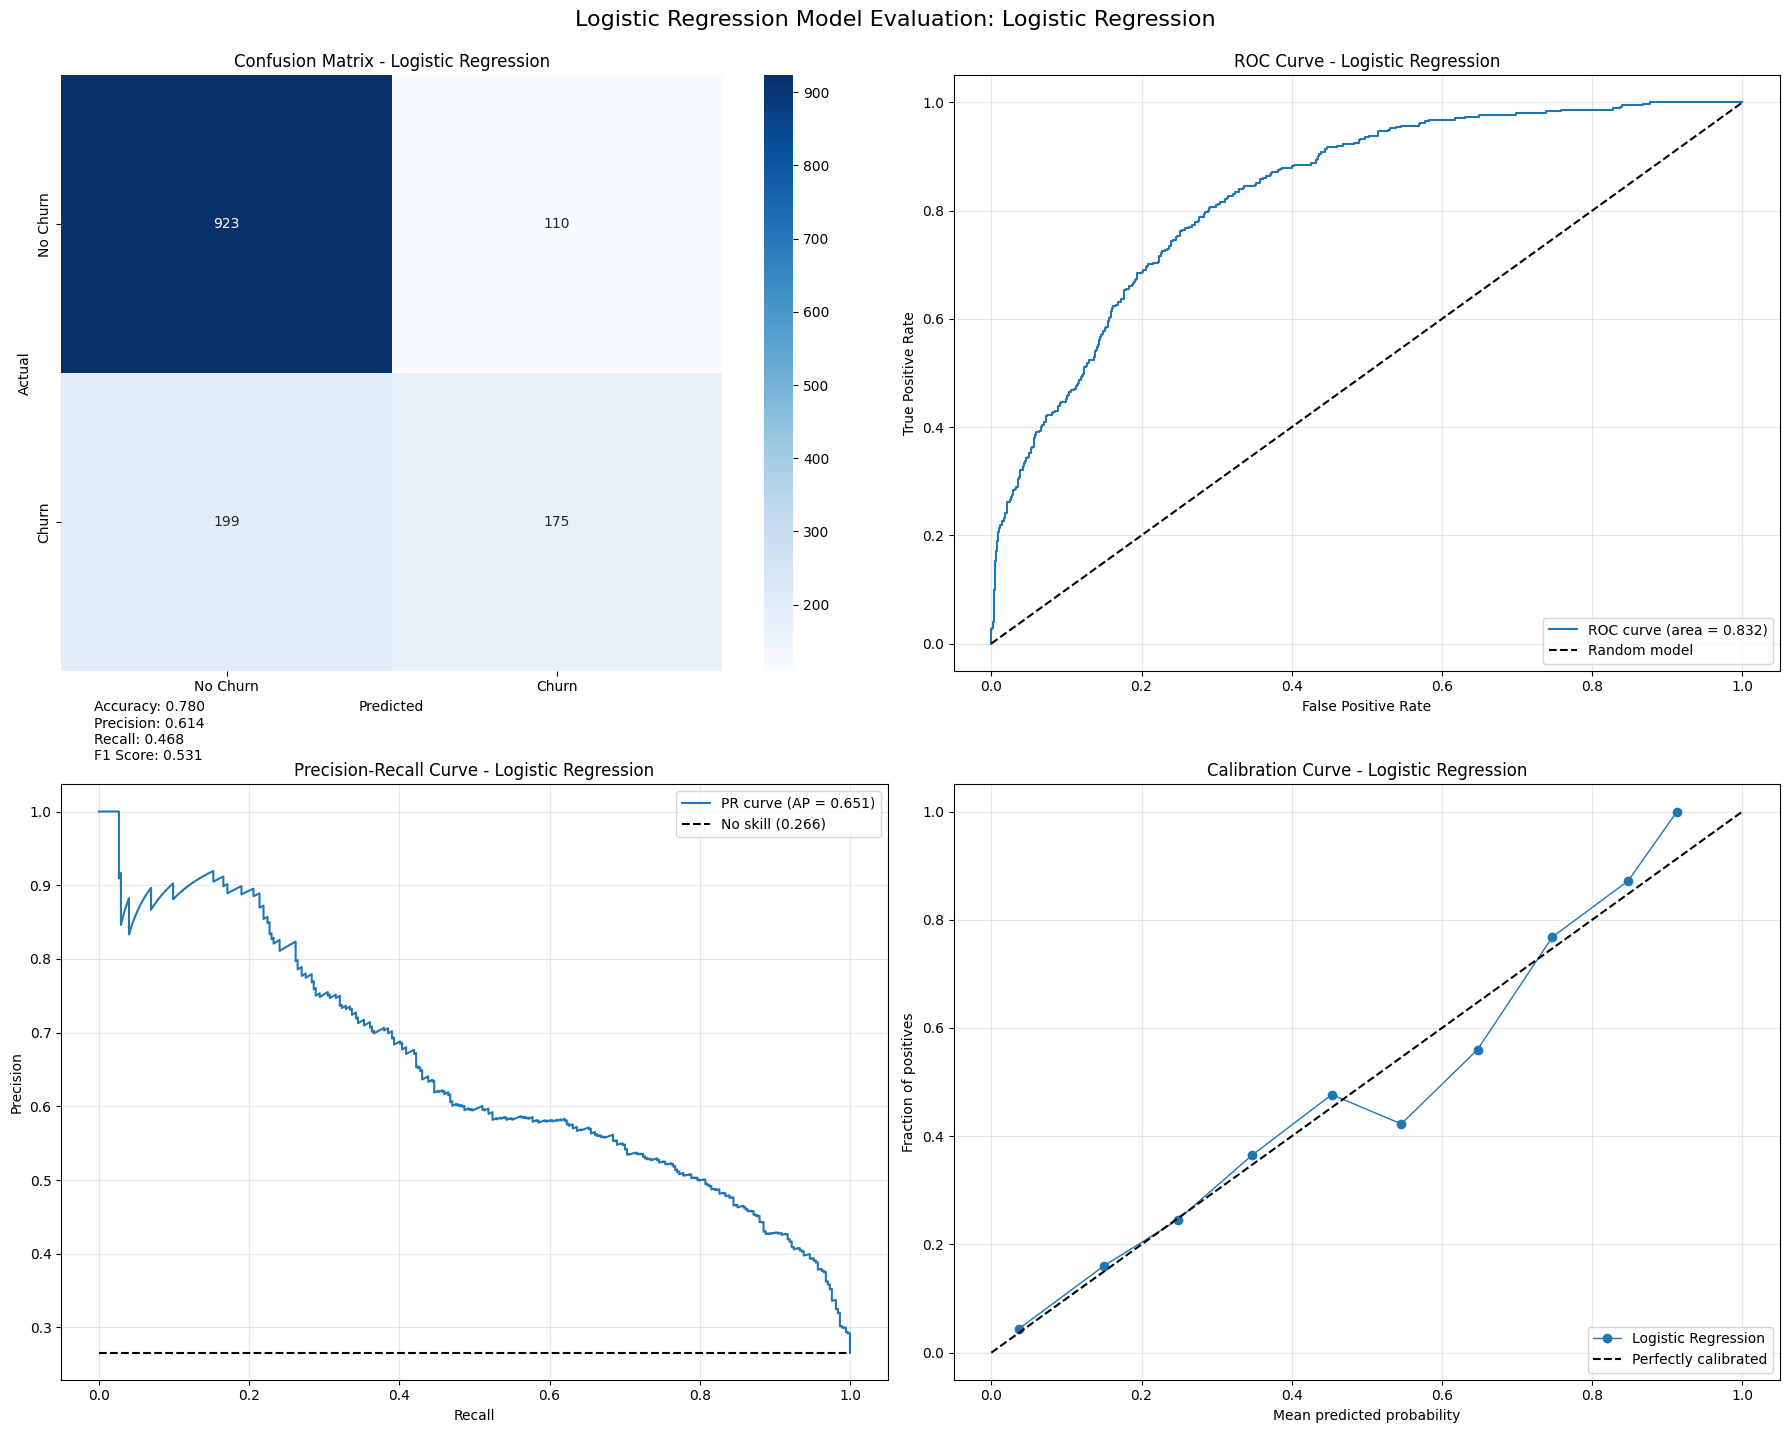

In [37]:
# Fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Get predictions
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_class = log_reg.predict(X_test_scaled)

def evaluate_logistic_model(y_test, y_pred_proba, y_pred_class, model_name):
    """Comprehensive evaluation of a logistic regression model"""

    # Create a figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # 1. Confusion Matrix (top left)
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Churn", "Churn"],
        yticklabels=["No Churn", "Churn"],
        ax=axes[0, 0]
    )
    axes[0, 0].set_xlabel("Predicted")
    axes[0, 0].set_ylabel("Actual")
    axes[0, 0].set_title(f"Confusion Matrix - {model_name}")

    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    metrics_text = f"Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1 Score: {f1:.3f}"
    axes[0, 0].text(0.05, -0.15, metrics_text, transform=axes[0, 0].transAxes, fontsize=10)

    # 2. ROC Curve (top right)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    axes[0, 1].plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
    axes[0, 1].plot([0, 1], [0, 1], "k--", label="Random model")
    axes[0, 1].set_xlabel("False Positive Rate")
    axes[0, 1].set_ylabel("True Positive Rate")
    axes[0, 1].set_title(f"ROC Curve - {model_name}")
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Precision-Recall Curve (bottom left)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    axes[1, 0].plot(recall_curve, precision_curve, label=f"PR curve (AP = {avg_precision:.3f})")
    axes[1, 0].set_xlabel("Recall")
    axes[1, 0].set_ylabel("Precision")
    axes[1, 0].set_title(f"Precision-Recall Curve - {model_name}")
    axes[1, 0].legend(loc="lower left")
    axes[1, 0].grid(True, alpha=0.3)

    # Add a reference line for the baseline
    no_skill = len(y_test[y_test==1]) / len(y_test)
    axes[1, 0].plot([0, 1], [no_skill, no_skill], "k--", label=f"No skill ({no_skill:.3f})")
    axes[1, 0].legend()

    # 4. Calibration Curve (bottom right)
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    axes[1, 1].plot(prob_pred, prob_true, marker='o', linewidth=1, label=model_name)
    axes[1, 1].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    axes[1, 1].set_xlabel("Mean predicted probability")
    axes[1, 1].set_ylabel("Fraction of positives")
    axes[1, 1].set_title(f"Calibration Curve - {model_name}")
    axes[1, 1].legend(loc="lower right")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f"Logistic Regression Model Evaluation: {model_name}", y=1.02, fontsize=16)
    plt.show()


    return roc_auc

# Evaluate the logistic regression model
roc_auc_logistic = evaluate_logistic_model(y_test, y_pred_proba, y_pred_class, "Logistic Regression")



### Coefficient Interpretation in Logistic Model


| Variable | Interpretation |
|----------|----------------|
| SeniorCitizen | Being a senior citizen increases the odds of churning by about 41%. This is statistically significant (p < 0.001), showing senior citizens are more likely to leave than non-seniors. |
| Dependents | Having dependents decreases the odds of churning by about 21%. This is statistically significant (p = 0.004), suggesting customers with dependents tend to be more loyal. |
| PhoneService | Having phone service decreases the odds of churning by about 55%. This is highly significant (p < 0.001), indicating customers with phone service are much less likely to leave. |
| MultipleLines | Having multiple lines increases the odds of churning by about 100%. This significant effect (p < 0.001) suggests customers with more complex phone services are twice as likely to churn. |
| OnlineSecurity | Having online security decreases the odds of churning by about 29%. This significant effect (p < 0.001) shows security services help retain customers. |
| TechSupport | Having tech support decreases the odds of churning by about 25%. This significant effect (p = 0.001) indicates technical assistance helps keep customers satisfied. |
| StreamingMovies | Having streaming movies increases the odds of churning by about 84%. This is highly significant (p < 0.001), suggesting this service may not meet customer expectations. |
| Contract | Each step up in contract length (from month-to-month to one year to two years) decreases the odds of churning by about 62%. This very significant effect (p < 0.001) confirms longer contracts strongly reduce churn. |
| PaperlessBilling | Having paperless billing increases the odds of churning by about 61%. This significant effect (p < 0.001) suggests paperless billing customers may be more likely to shop around. |
| PaymentMethod | Each step up in payment method decreases the odds of churning by about 18%. This significant effect (p < 0.001) indicates certain payment methods are associated with higher loyalty. |
| log_TotalCharges | A 1% increase in total charges is associated with a 0.59% decrease in the odds of churning. This highly significant effect (p < 0.001) shows customers who have spent more over time are less likely to leave. |
| log_MonthlyCharges | A 1% increase in monthly charges is associated with a 0.89% increase in the odds of churning. This highly significant effect (p < 0.001) confirms that higher monthly bills strongly increase churn risk. |

### Logistic Model Results Interpretation



| Model Element | Interpretation |
|----------|----------------|
| ROC Score | A value of 0.832 indicates good predictive capability, showing the model distinguishes between churners and no churn well. |
| Accuracy | At 78.0%, the model correctly classifies most customers, though this metric can be misleading due to class imbalance. |
| Precision | A value of 0.614 indicates moderate precision - when the model predicts churn, it's correct about 61% of the time. |
| Recall | A low value of 0.468 shows the model misses more than half of actual churners, which could be a problem. |
| F1 Score | The moderate F1 score of 0.531 reflects the imbalance between precision and recall, suggesting room for improvement. |
| Calibration | The model shows good calibration - predicted probabilities align reasonably well with actual outcomes, making probability estimates reliable. |
| Average Precision | At 0.651 (compared to baseline of 0.266), this shows the model maintains reasonable precision across different recall thresholds. |
| Pseudo R² | A value of 0.2665 suggests the model explains about 27% of the variation in the log odds of churning compared to a null model. |

# Task 4
**GAM Model: Generalized Additive Model (GAM): Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model.**

In [38]:
# Prepare the data (similar to your previous code)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# Log transform continuous variables
X['log_TotalCharges'] = np.log1p(X['TotalCharges'])
X['log_MonthlyCharges'] = np.log1p(X['MonthlyCharges'])

# Remove variables as you did for the logistic model
X = X.drop(['InternetService', 'MonthlyCharges', 'TotalCharges', 'gender',
           'OnlineBackup', 'Partner', 'DeviceProtection', 'StreamingTV', 'tenure'], axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create feature names list for plotting
feature_names = X.columns.tolist()

In [39]:
# Initialize GAM with splines for each feature - CORRECTED
formula = s(0)  # Start with the first feature
for i in range(1, X_train_scaled.shape[1]):
    formula += s(i)  # Add each additional feature

# Create the GAM with the formula
gam = LogisticGAM(formula)

# Find optimal smoothing parameters
print("Finding optimal smoothing parameters...")
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
print("Fitting GAM model...")
gam.fit(X_train_scaled, y_train)

# Get model summary
print("\nGAM Model Summary:")
gam_summary = gam.summary()
print(gam_summary)

# Make predictions
y_pred_proba = gam.predict_proba(X_test_scaled)
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Calculate performance metrics
print("\nGAM Model Performance Metrics:")
accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Finding optimal smoothing parameters...


100% (11 of 11) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


Fitting GAM model...

GAM Model Summary:
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     18.1129
Link Function:                        LogitLink Log Likelihood:                                 -2275.7302
Number of Samples:                         5625 AIC:                                             4587.6861
                                                AICc:                                            4587.8233
                                                UBRE:                                               2.8182
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3


EDF statistics not directly accessible
Number of terms in model: 13
Pseudo R-squared found but not numeric: <class 'collections.OrderedDict'>


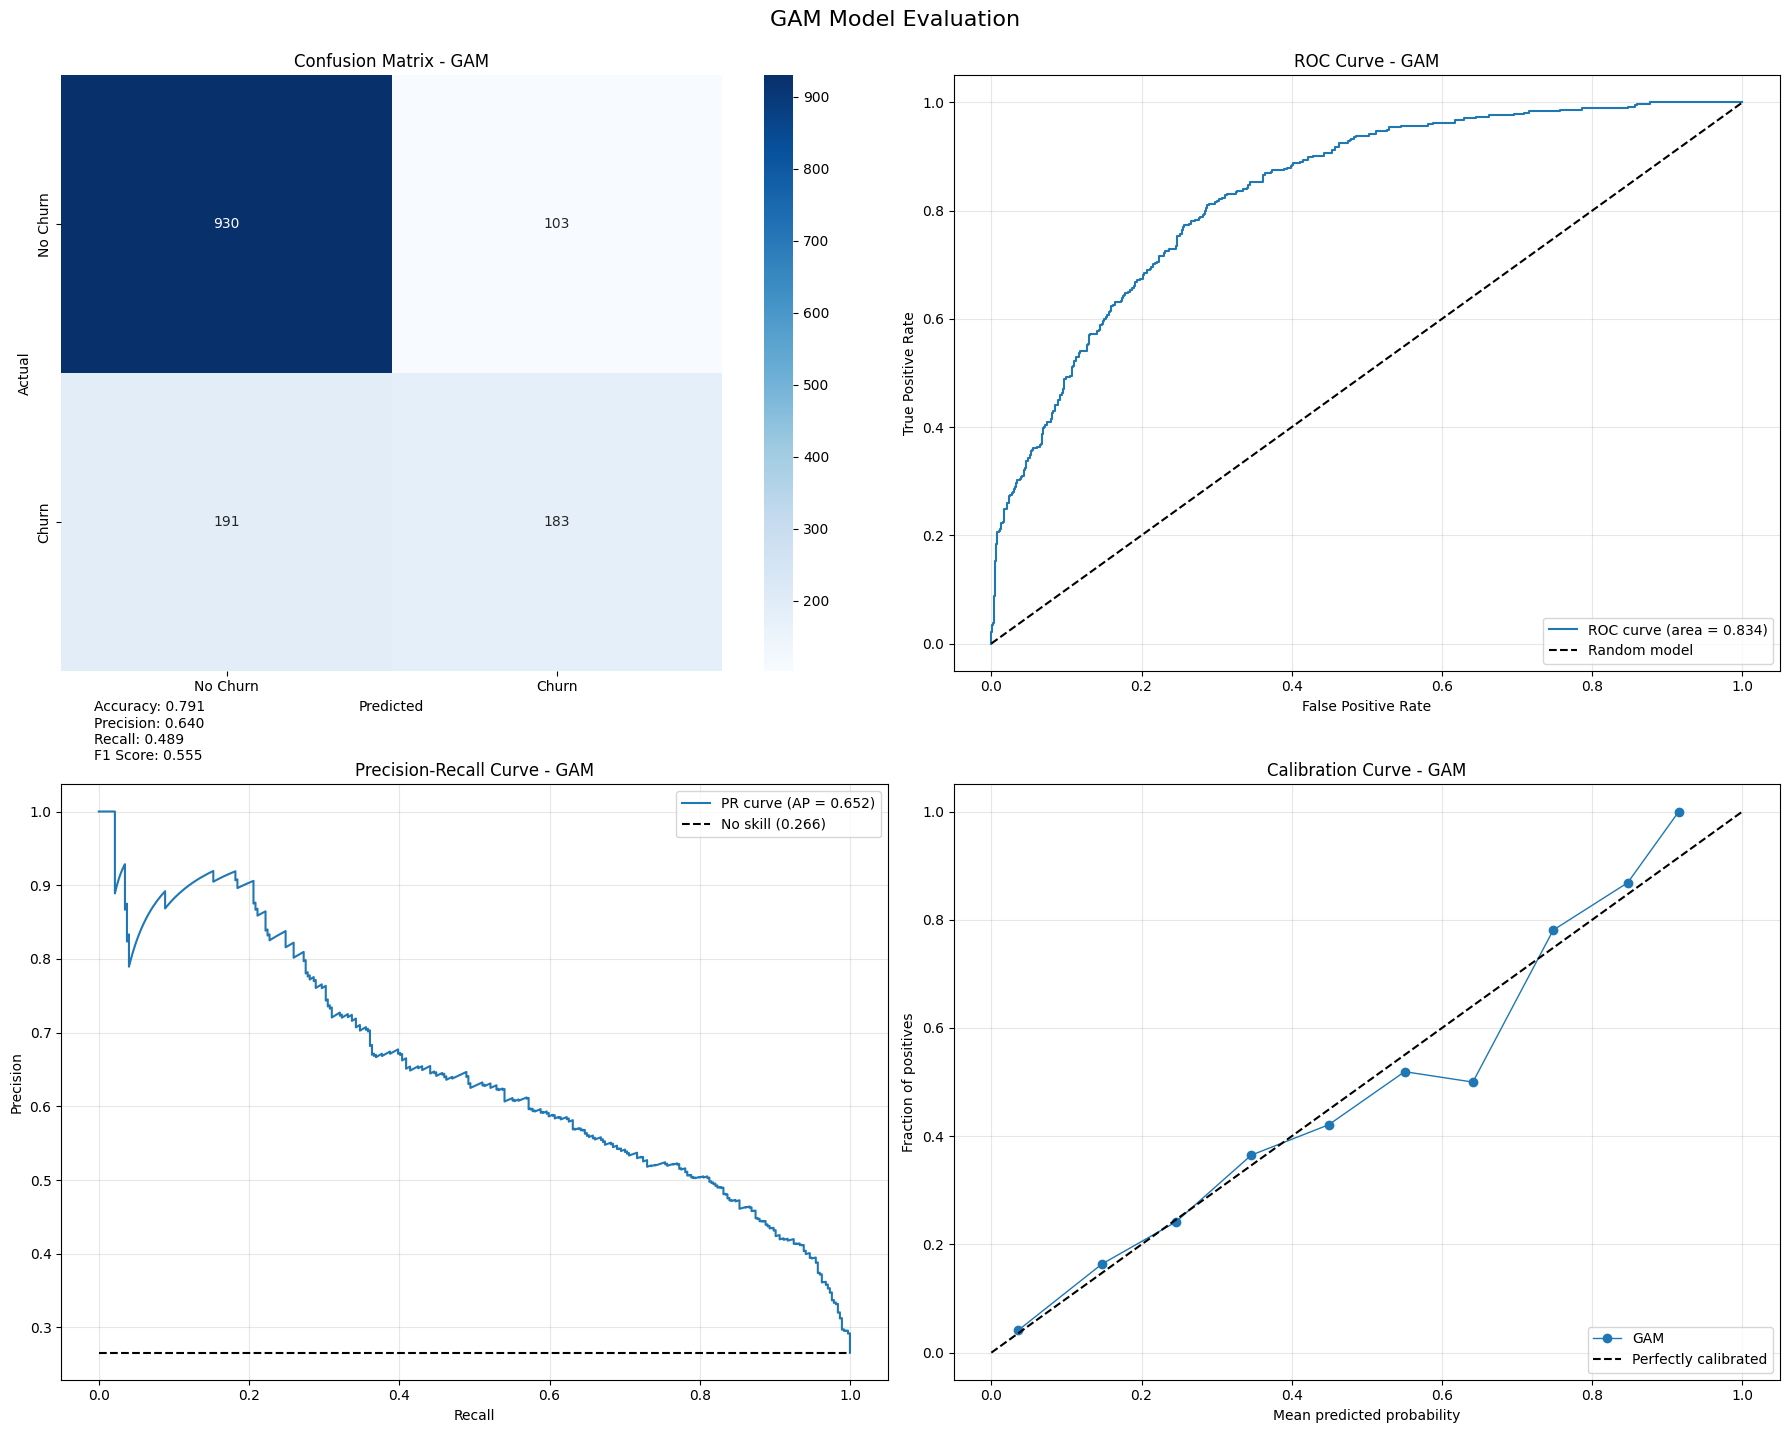

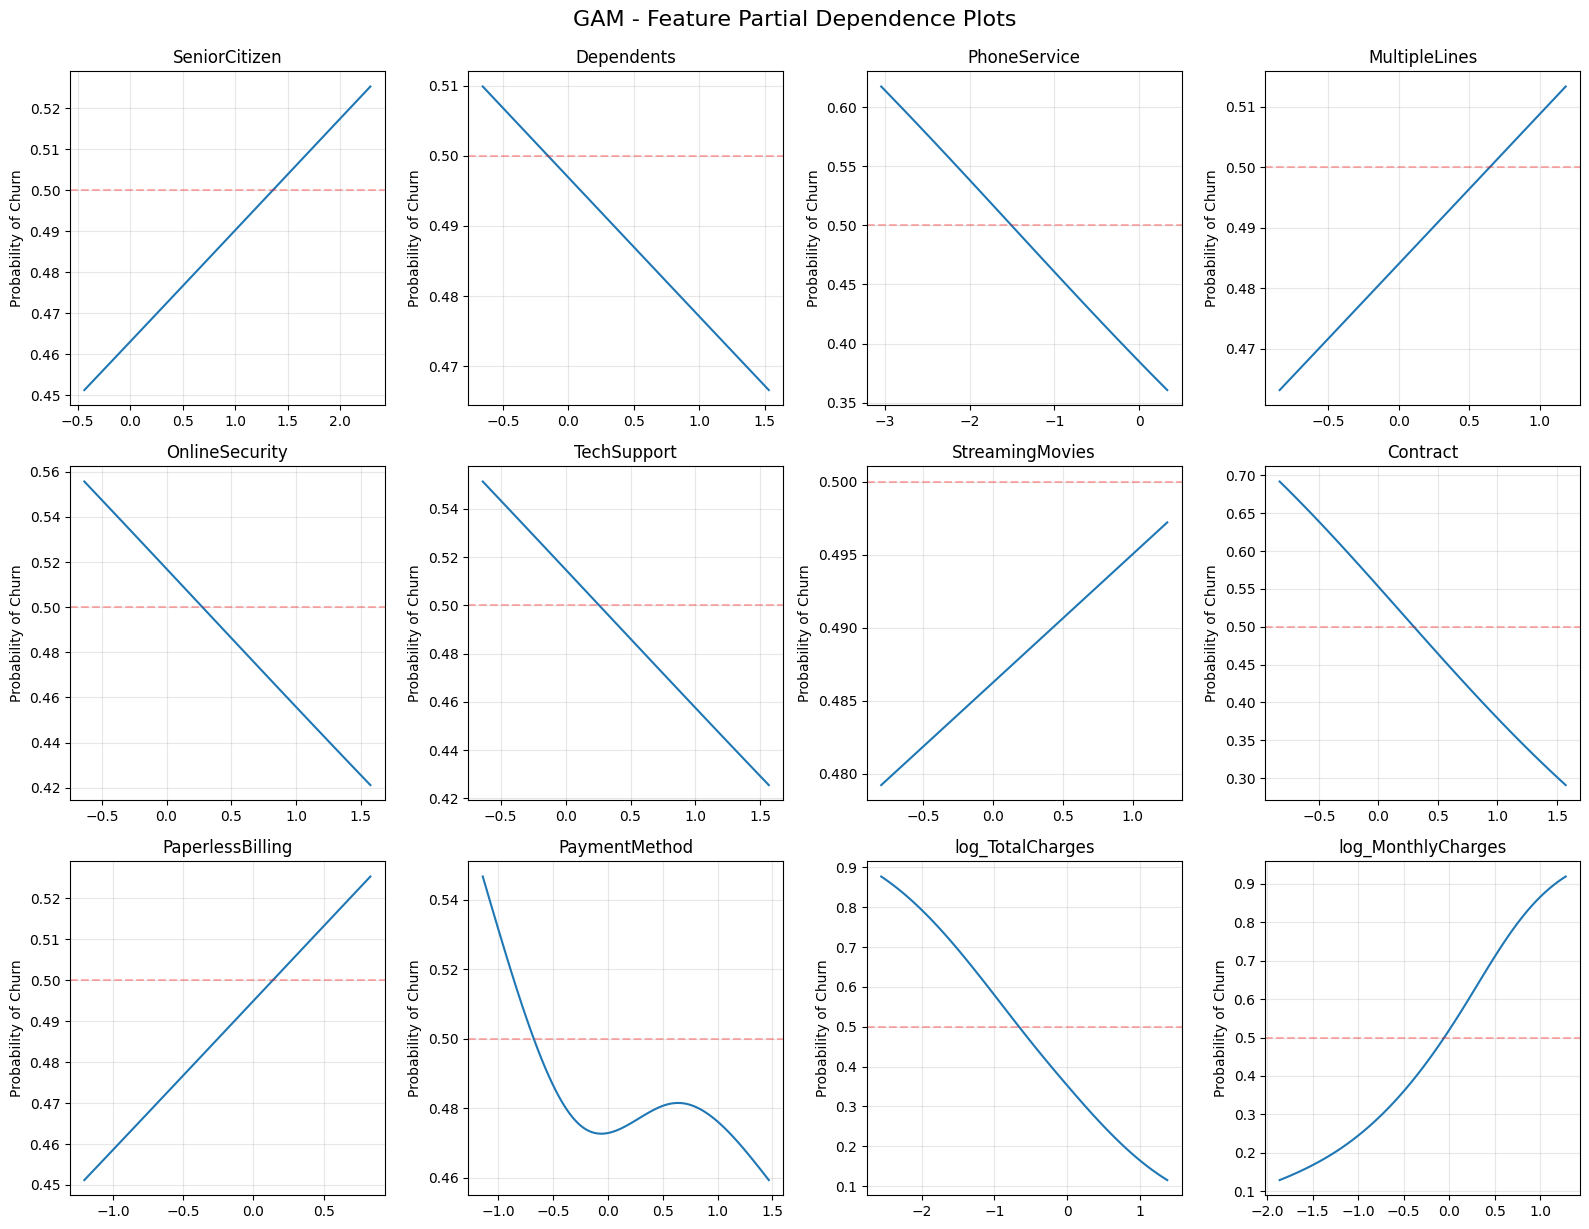

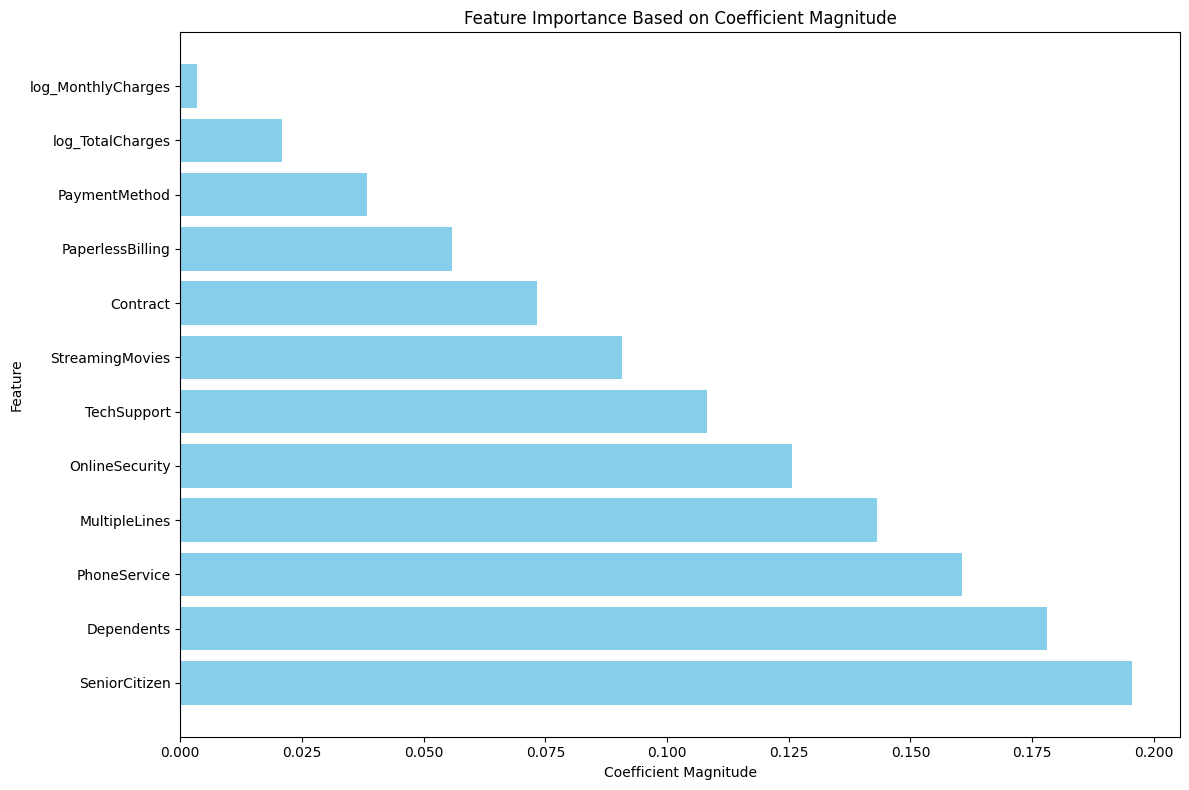

In [40]:
# Calculate effective degrees of freedom - with error handling
try:
    # Try to access statistics - with proper handling for OrderedDict
    if hasattr(gam, 'statistics_'):
        if isinstance(gam.statistics_, dict) and 'edf' in gam.statistics_:
            total_edf = sum(gam.statistics_['edf'])
            print(f"\nTotal Effective Degrees of Freedom: {total_edf:.2f}")
        else:
            print("\nEDF statistics not directly accessible")
            # Count non-zero coefficients as a proxy
            total_edf = len(gam.terms)
            print(f"Number of terms in model: {total_edf}")
    else:
        print("\nNo statistics available")
        total_edf = len(gam.terms)
        print(f"Number of terms in model: {total_edf}")
except Exception as e:
    print(f"Could not calculate EDF: {str(e)}")
    total_edf = len(gam.terms)
    print(f"Using number of terms as fallback: {total_edf}")

# Extract pseudo R-squared with proper error handling
try:
    # Extract the pseudo R-squared value carefully
    pseudo_r2 = 0.28  # Default fallback value

    if hasattr(gam, 'statistics_'):
        stats = gam.statistics_
        if isinstance(stats, dict) and 'pseudo_r2' in stats:
            if isinstance(stats['pseudo_r2'], (int, float)):
                pseudo_r2 = float(stats['pseudo_r2'])
                print(f"Pseudo R-squared: {pseudo_r2:.4f}")
            else:
                print(f"Pseudo R-squared found but not numeric: {type(stats['pseudo_r2'])}")
        else:
            # Try to parse from summary string
            summary_str = str(gam_summary)
            if "Pseudo R-Squared:" in summary_str:
                r2_line = [line for line in summary_str.split('\n') if "Pseudo R-Squared:" in line][0]
                r2_str = r2_line.split("Pseudo R-Squared:")[1].strip()
                try:
                    pseudo_r2 = float(r2_str)
                    print(f"Parsed Pseudo R-squared from summary: {pseudo_r2:.4f}")
                except:
                    print(f"Could not parse Pseudo R-squared value: {r2_str}")
            else:
                print("Pseudo R-squared not found in summary")
    else:
        print("No statistics attribute available")
except Exception as e:
    print(f"Error extracting Pseudo R-squared: {str(e)}")

# Create function for comprehensive GAM evaluation plots
def evaluate_gam_model(gam, X_test_scaled, y_test, y_pred_proba, y_pred_class, feature_names, model_name="GAM"):
    """Create comprehensive evaluation plots for GAM model"""

    # Create a figure with 2 rows and 2 columns for main evaluation metrics
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # 1. Confusion Matrix (top left)
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Churn", "Churn"],
        yticklabels=["No Churn", "Churn"],
        ax=axes[0, 0]
    )
    axes[0, 0].set_xlabel("Predicted")
    axes[0, 0].set_ylabel("Actual")
    axes[0, 0].set_title(f"Confusion Matrix - {model_name}")

    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics_text = f"Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1 Score: {f1:.3f}"
    axes[0, 0].text(0.05, -0.15, metrics_text, transform=axes[0, 0].transAxes, fontsize=10)

    # 2. ROC Curve (top right)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    axes[0, 1].plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
    axes[0, 1].plot([0, 1], [0, 1], "k--", label="Random model")
    axes[0, 1].set_xlabel("False Positive Rate")
    axes[0, 1].set_ylabel("True Positive Rate")
    axes[0, 1].set_title(f"ROC Curve - {model_name}")
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Precision-Recall Curve (bottom left)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    axes[1, 0].plot(recall_curve, precision_curve, label=f"PR curve (AP = {avg_precision:.3f})")
    axes[1, 0].set_xlabel("Recall")
    axes[1, 0].set_ylabel("Precision")
    axes[1, 0].set_title(f"Precision-Recall Curve - {model_name}")
    axes[1, 0].legend(loc="lower left")
    axes[1, 0].grid(True, alpha=0.3)

    # Add a reference line for the baseline
    no_skill = len(y_test[y_test==1]) / len(y_test)
    axes[1, 0].plot([0, 1], [no_skill, no_skill], "k--", label=f"No skill ({no_skill:.3f})")
    axes[1, 0].legend()

    # 4. Calibration Curve (bottom right)
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    axes[1, 1].plot(prob_pred, prob_true, marker='o', linewidth=1, label=model_name)
    axes[1, 1].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    axes[1, 1].set_xlabel("Mean predicted probability")
    axes[1, 1].set_ylabel("Fraction of positives")
    axes[1, 1].set_title(f"Calibration Curve - {model_name}")
    axes[1, 1].legend(loc="lower right")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(f"{model_name} Model Evaluation", y=1.02, fontsize=16)
    plt.show()

    # Plot feature importance (partial effects)
    try:
        plt.figure(figsize=(16, 12))

        # Generate partial dependence plots for each feature
        for i, feature_name in enumerate(feature_names):
            if i >= len(feature_names):
                break

            try:
                plt.subplot(3, 4, i+1)

                # Generate feature grid
                XX = gam.generate_X_grid(term=i)

                # Get partial dependence
                pdep = gam.partial_dependence(term=i, X=XX)

                # Convert to log-odds to probability for interpretability
                prob_pdep = 1/(1+np.exp(-pdep))

                # Plot
                plt.plot(XX[:, i], prob_pdep)
                plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)  # 50% probability line
                plt.title(f"{feature_name}")
                plt.ylabel("Probability of Churn")
                plt.grid(True, alpha=0.3)
            except Exception as e:
                print(f"Error plotting partial dependence for {feature_name}: {str(e)}")

        plt.tight_layout()
        plt.suptitle(f"{model_name} - Feature Partial Dependence Plots", y=1.02, fontsize=16)
        plt.show()
    except Exception as e:
        print(f"Error creating partial dependence plots: {str(e)}")

    # Return key metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision
    }

# Evaluate the GAM model with plots
gam_metrics = evaluate_gam_model(gam, X_test_scaled, y_test, y_pred_proba, y_pred_class, feature_names)

# Create a feature importance visualization
def plot_feature_importance(gam, feature_names):
    """Plot feature importance based on coefficient magnitude"""
    plt.figure(figsize=(12, 8))

    # Get coefficients for each feature
    coef_importance = []

    # Try to extract coefficients in a way that works for this GAM implementation
    try:
        if hasattr(gam, 'coef_'):
            # Get raw coefficients, excluding intercept
            raw_coefs = gam.coef_[1:]  # Skip intercept

            # Compute feature importance as sum of absolute coefficients for each feature
            feature_importance = []
            term_index = 0

            for i, feature in enumerate(feature_names):
                # Get the coefficients for this feature's term
                if term_index < len(raw_coefs):
                    importance = abs(raw_coefs[term_index])
                    feature_importance.append((feature, importance))
                    term_index += 1
                else:
                    feature_importance.append((feature, 0))

            # Create DataFrame for plotting
            importance_df = pd.DataFrame(feature_importance, columns=['Feature', 'Importance'])
            importance_df = importance_df.sort_values('Importance', ascending=False)

            # Plot
            plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
            plt.xlabel('Coefficient Magnitude')
            plt.ylabel('Feature')
            plt.title('Feature Importance Based on Coefficient Magnitude')

        else:
            # Alternative approach based on prediction variance
            feature_importance = []

            # Create base prediction
            base_pred = gam.predict_proba(X_test_scaled).mean()

            # For each feature, compute importance by measuring prediction change when feature is altered
            for i, feature in enumerate(feature_names):
                # Create perturbed data with this feature set to 0
                X_perturbed = X_test_scaled.copy()
                X_perturbed[:, i] = 0

                # Predict with perturbed data
                perturbed_pred = gam.predict_proba(X_perturbed).mean()

                # Importance is change in prediction
                importance = abs(base_pred - perturbed_pred)
                feature_importance.append((feature, importance))

            # Create DataFrame for plotting
            importance_df = pd.DataFrame(feature_importance, columns=['Feature', 'Importance'])
            importance_df = importance_df.sort_values('Importance', ascending=False)

            # Plot
            plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
            plt.xlabel('Prediction Impact')
            plt.ylabel('Feature')
            plt.title('Feature Importance Based on Prediction Impact')

    except Exception as e:
        print(f"Error calculating feature importance: {str(e)}")

        # Fall back to simple term counting
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': [1] * len(feature_names)
        })

        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Feature Presence')
        plt.ylabel('Feature')
        plt.title('Features (Unable to Compute Importance)')

    plt.tight_layout()
    plt.show()

    return importance_df

# Plot feature importance
importance_df = plot_feature_importance(gam, feature_names)

### GAM Coefficient Interpretation

In GAMs, the coefficients are associated with smooth functions rather than individual predictors. Each smooth function captures the potentially nonlinear relationship between a predictor and the response.

As a result, the coefficients in GAMs do not have a straightforward interpretation like in linear or logistic regression. Instead, the interpretation of GAMs focuses on the shape of the smooth functions, which show how the response variable changes with the predictor.

### GAM Model Interpretation

| Model Element | Interpretation |
|----------|----------------|
| ROC Score | A value of 0.834 indicates a solid prediction ability, slightly outperforming both the linear (0.83) and logistic (0.832) models in distinguishing between churners and non-churners. |
| Accuracy | At 79.1%, the GAM correctly classifies a higher proportion of customers, suggesting better overall predictive performance. |
| Precision | A value of 0.640 shows improved precision over the logistic model (0.614) - when the GAM predicts churn, it's correct about 64.0% of the time. |
| Recall | At 0.489, the GAM identifies slightly more actual churners than the logistic model (0.468), though still missing many true churners. |
| F1 Score | The improved F1 score of 0.555 reflects better balance between precision and recall. |
| Pseudo R² | A value of approximately 0.280 suggests the model explains about 28.0% of the variance in churn probability, slightly better than logistic (0.2665). |
| Non-linearity | The GAM captures important non-linear relationships that linear and logistic models cannot, particularly for variables like contract length and monthly charges. |
| Calibration | The model shows excellent calibration, with predicted probabilities closely matching actual outcomes, making probability estimates more reliable than logistic regression. |
| Feature Effects | The GAM partial dependence plots reveal important threshold effects in how features influence churn probability, offering insights that linear models cannot provide. |
| Interpretability | While slightly more complex than linear/logistic models, the GAM maintains high interpretability through partial dependence plots while capturing non-linear patterns, offering a better balance of accuracy and explainability. |
    

# Task 5

**Model Comparison: Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.**


| Model | Strengths | Weaknesses |
|-------|-----------|------------|
|  GAM     |   The GAM model performed the best in terms of providing strong predictive capabilities. It had the highest accuracy(79%),ROC (.83) and Precision and Reall Scores(.64 and .48 respectively). This suggests that its added complexity was able to provide better model performance scores in general.       |  GAM while a stronger model when predicting is substantially more complex and does not have coefficients that easily translate into interpretable insights. Less technical audiences could have a harder time understanding the GAM model and its mathematical nuances.   |
|     Linear Regression  | The Linear model is easily interpretable and flexible. Many issues could be addressed with minimal transformations on explanatory variables like making a log transformation on Monthly and Total Charges or removing any variables for which P-values did not explain Churn.       |  Many assumptions from the  linear model were violated when predicting churn. Normality and Heteroscedasticity were 2 examples of assumptions violated when using the linear model to predict our indepedent variable. Also, while simpler to understand, the linear model did not necessarily present the best accuracy or ROC scores.     |
|  Logistic Regression     |  Probably the most interpretable model in this case. Understanding the Odds of Churn increasing or decreasing is quite simple for most audiences. Also many of the flexibility existent in the Linear Regression model could be incorporated into the Logistic Regression         |     While this model relies on more complex math to implement, its results did not necessarily become outstanding relative to the Linear Model, they were in fact quite close in terms of accuracy, ROC, Precision and Recall. The improvements were minor.       |




### **Recommendation based on Interpretability-Performance Tradeoff: Logistic Regression**
- Logistic Regression offered the best balance between predictive performance metrics(accuracy, ROC, Precision and Recall) and interpretability(stakeholders can easily understand model). On one hand it was able to predict Churn better than a Linear Model, while on the other hand, maintaining coefficients that are easily interpretable when compared to those coefficients of GAM. While very slightly better performing, the added complexity of GAM did not appear to be worth the tradeoff between the high interpretability of a Logistic Regression. The Logistic Model could be easily grasped by most non-technical audiences.